In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LambdaCallback
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import librosa
import librosa.display
import joblib
import pickle
import cv2
import warnings
warnings.filterwarnings('ignore')

In [2]:
def extract_advanced_features(audio_path, max_length=5.0):
    """
    สกัดคุณลักษณะที่หลากหลายจากไฟล์เสียง
    """
    try:
        # โหลดไฟล์เสียง
        y, sr = librosa.load(audio_path, sr=22050)
        
        # ปรับความยาวเสียงให้เท่ากัน
        target_length = int(max_length * sr)
        
        if len(y) > target_length:
            y = y[:target_length]
        else:
            # Pad with zeros
            padding = target_length - len(y)
            y = np.pad(y, (0, padding), 'constant')
        
        # 1. Mel Spectrogram - ให้ความสำคัญมากที่สุด
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, 
                                                fmax=8000, n_fft=2048, hop_length=512)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # 2. MFCC - Mel-frequency cepstral coefficients
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        delta_mfcc = librosa.feature.delta(mfcc)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)
        
        # รวม features แบบมัลติ-แชนแนล (3 ช่อง)
        # Normalize features
        mel_spec_norm = (mel_spec_db - np.mean(mel_spec_db)) / (np.std(mel_spec_db) + 1e-10)
        mfcc_norm = (mfcc - np.mean(mfcc)) / (np.std(mfcc) + 1e-10)
        delta_norm = (delta_mfcc - np.mean(delta_mfcc)) / (np.std(delta_mfcc) + 1e-10)
        
        # ปรับขนาดให้เท่ากัน
        target_shape = (128, 128)
        mel_spec_resized = cv2.resize(mel_spec_norm, (target_shape[1], target_shape[0]))
        mfcc_resized = cv2.resize(mfcc_norm, (target_shape[1], target_shape[0]))
        delta_resized = cv2.resize(delta_norm, (target_shape[1], target_shape[0]))
        
        # รวมเป็นภาพ 3 ช่อง (RGB-like)
        feature_image = np.stack([mel_spec_resized, mfcc_resized, delta_resized], axis=-1)
        
        # ทำให้ค่าอยู่ระหว่าง 0-1
        feature_image = (feature_image - feature_image.min()) / (feature_image.max() - feature_image.min() + 1e-10)
        
        return feature_image
    except Exception as e:
        print(f"Error extracting features from {audio_path}: {str(e)}")
        return None

def load_and_preprocess_data(data_dir, selected_accents, max_samples=150):
    X = []
    y = []
    file_paths = []
    
    print("กำลังโหลดข้อมูลเสียง...")
    print(f"โฟลเดอร์ข้อมูล: {data_dir}")
    
    # ตรวจสอบว่าโฟลเดอร์ข้อมูลมีอยู่จริง
    if not os.path.exists(data_dir):
        print(f"ไม่พบโฟลเดอร์ข้อมูล: {data_dir}")
        return None, None, None, None
    
    # สร้าง Label Encoder
    label_encoder = LabelEncoder()
    label_encoder.fit(selected_accents)
    
    # โหลดข้อมูลจากแต่ละสำเนียงที่เลือก
    total_files_found = 0
    for accent in selected_accents:
        accent_dir = os.path.join(data_dir, accent)
        if not os.path.isdir(accent_dir):
            print(f"ไม่พบโฟลเดอร์สำหรับสำเนียง {accent} ที่ {accent_dir}")
            continue
        
        accent_files = [os.path.join(accent_dir, f) for f in os.listdir(accent_dir) 
                       if f.endswith('.wav') or f.endswith('.mp3')]
        
        total_files_found += len(accent_files)
        
        # จำกัดจำนวนตัวอย่างต่อสำเนียง
        if max_samples and len(accent_files) > max_samples:
            accent_files = accent_files[:max_samples]
        
        print(f"กำลังประมวลผลสำเนียง {accent}: พบ {len(accent_files)} ไฟล์")
        
        files_processed = 0
        for file_path in accent_files:
            features = extract_advanced_features(file_path)
            if features is not None:
                X.append(features)
                y.append(accent)
                file_paths.append(file_path)
                files_processed += 1
        
        print(f"  - ประมวลผลสำเร็จ {files_processed} ไฟล์")
    
    print(f"พบไฟล์เสียงทั้งหมด: {total_files_found}")
    print(f"ประมวลผลสำเร็จ: {len(X)} ไฟล์")
    
    if len(X) == 0:
        print("ไม่มีข้อมูลที่ประมวลผลได้ โปรดตรวจสอบข้อมูลเสียงของคุณ")
        return None, None, None, None
    
    # แปลง list เป็น numpy array
    X = np.array(X)
    
    # แปลงป้ายกำกับเป็น one-hot encoding
    y_encoded = label_encoder.transform(y)
    y_one_hot = to_categorical(y_encoded)
    
    print(f"โหลดข้อมูลเสร็จสิ้น: {X.shape[0]} ตัวอย่าง, คุณลักษณะ shape: {X.shape[1:]}")
    
    return X, y_one_hot, label_encoder, file_paths

In [3]:
def build_cnn_rnn_model(input_shape, num_classes):
    """
    สร้างโมเดลแบบผสมผสาน CNN + RNN สำหรับการตรวจจับสำเนียง
    """
    # Input layer
    inputs = Input(shape=input_shape)
    
    # CNN Blocks - สกัดคุณลักษณะเชิงพื้นที่
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Reshape เพื่อให้เข้ากับ RNN
    reshape_dim = K.int_shape(x)
    x = Reshape((reshape_dim[1], reshape_dim[2] * reshape_dim[3]))(x)
    
    # RNN Layers - จับลักษณะเชิงลำดับเวลา
    x = Bidirectional(GRU(128, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(GRU(128))(x)
    x = Dropout(0.3)(x)
    
    # Global Features
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [4]:
def residual_block(x, filters, kernel_size=3):
    """
    สร้างบล็อก Residual สำหรับโมเดล ResNet
    """
    # แบบ Residual Block ช่วยให้เทรนโมเดลลึกได้มากขึ้น
    y = Conv2D(filters, kernel_size, padding='same')(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(filters, kernel_size, padding='same')(y)
    y = BatchNormalization()(y)
    
    # สร้าง shortcut connection
    if K.int_shape(x)[-1] != filters:
        x = Conv2D(filters, 1, padding='same')(x)
        x = BatchNormalization()(x)
    
    out = Add()([x, y])
    out = Activation('relu')(out)
    return out

def build_resnet_model(input_shape, num_classes):
    """
    สร้างโมเดลแบบ ResNet สำหรับการตรวจจับสำเนียง
    """
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Initial Conv Layer
    x = Conv2D(32, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    # Residual blocks
    x = residual_block(x, 32)
    x = residual_block(x, 32)
    x = MaxPooling2D(2, strides=2, padding='same')(x)
    
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = MaxPooling2D(2, strides=2, padding='same')(x)
    
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    
    # Final layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [5]:
def positional_encoding(position, d_model):
    """
    สร้าง positional encoding สำหรับ Transformer
    """
    def get_angles(pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates
    
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    
    # sin ใช้สำหรับตำแหน่งคู่ (0, 2, 4, ...)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # cos ใช้สำหรับตำแหน่งคี่ (1, 3, 5, ...)
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

def scaled_dot_product_attention(q, k, v, mask=None):
    """
    คำนวณ scaled dot product attention
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    # add mask (optional)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  
    
    # softmax normalization
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

class MultiHeadAttention(Layer):
    """
    Multi-head attention layer
    """
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)
        
        self.dense = Dense(d_model)
    
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, 
                                     (batch_size, -1, self.d_model))
        
        output = self.dense(concat_attention)
        
        return output

def point_wise_feed_forward_network(d_model, dff):
    """
    Simple feed forward network for transformer
    """
    return Sequential([
        Dense(dff, activation='relu'),
        Dense(d_model)
    ])

class EncoderLayer(Layer):
    """
    Encoder layer for transformer
    """
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    
    def call(self, x, training=True):
        attn_output = self.mha(x, x, x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2

def build_transformer_model(input_shape, num_classes):
    """
    สร้างโมเดล Transformer-based สำหรับการตรวจจับสำเนียง
    """
    # Input layer
    inputs = Input(shape=input_shape)
    
    # ใช้ CNN เพื่อสกัดคุณลักษณะ
    x = Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)
    
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)
    
    x = Conv2D(128, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)
    
    # Reshape สำหรับ Transformer
    shape_before_flatten = K.int_shape(x)
    x = Reshape((shape_before_flatten[1] * shape_before_flatten[2], shape_before_flatten[3]))(x)
    
    # โปรเจคชั่นเป็นมิติของ Transformer
    d_model = 128
    x = Dense(d_model)(x)
    
    # เพิ่ม positional encoding
    seq_len = shape_before_flatten[1] * shape_before_flatten[2]
    pos_encoding = positional_encoding(seq_len, d_model)
    x = x + pos_encoding[:, :seq_len, :]
    
    # Dropout
    x = Dropout(0.2)(x)
    
    # Transformer encoder layers
    num_layers = 2
    for i in range(num_layers):
        x = EncoderLayer(d_model=d_model, num_heads=4, dff=256, rate=0.2)(x)
    
    # Global pooling
    x = GlobalAveragePooling1D()(x)
    
    # Final layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [6]:
def train_model_with_advanced_techniques(model, X_train, y_train, X_val, y_val, epochs=200, batch_size=32, model_path='model.h5'):
    """
    ฝึกสอนโมเดลด้วยเทคนิคขั้นสูงเพื่อเพิ่มประสิทธิภาพ
    """
    # ระบบ Callbacks ที่หลากหลาย
    callbacks = [
        # บันทึกโมเดลที่ดีที่สุด
        ModelCheckpoint(
            filepath=model_path,
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        # ปรับลด learning rate เมื่อประสิทธิภาพไม่ดีขึ้น
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1
        ),
        # หยุดการฝึกสอนเมื่อไม่มีการพัฒนา
        EarlyStopping(
            monitor='val_accuracy',
            patience=30,
            restore_best_weights=True,
            verbose=1
        ),
        # บันทึก learning rate ในแต่ละ epoch
        LambdaCallback(
            on_epoch_end=lambda epoch, logs: logs.update({'learning_rate': float(K.get_value(model.optimizer.learning_rate))})
        )
    ]
    
    # Class weight balancing สำหรับข้อมูลที่ไม่สมดุล
    # คำนวณน้ำหนักของแต่ละคลาส
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(np.argmax(y_train, axis=1)),
        y=np.argmax(y_train, axis=1)
    )
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    
    # ฝึกสอนโมเดล
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )
    
    # โหลดโมเดลที่ดีที่สุด
    best_model = load_model(model_path)
    
    return history, best_model

In [7]:
def evaluate_and_visualize(model, X_test, y_test, class_names, label_encoder, history=None, is_ensemble=False):
    """
    ประเมินโมเดลและแสดงผลด้วยภาพ
    """
    # ทำนายด้วยชุดข้อมูลทดสอบ
    if is_ensemble:
        y_pred_probs = ensemble_predict(model, X_test)
    else:
        # ประเมินโมเดล
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
        print(f"\nความแม่นยำบนชุดข้อมูลทดสอบ: {test_accuracy * 100:.2f}%")
        y_pred_probs = model.predict(X_test)
    
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # แสดงผลการประเมิน
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print("\n===== รายงานประสิทธิภาพโมเดล =====")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")
    
    print("\n===== รายงานการจำแนกประเภทโดยละเอียด =====")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # แสดง Confusion Matrix ด้วย Seaborn
    plt.figure(figsize=(14, 12))
    cm = confusion_matrix(y_true, y_pred)
    
    # แสดงทั้งจำนวนและเปอร์เซ็นต์
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # สร้าง custom annotation
    annot = np.empty_like(cm, dtype=str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'
    
    ax = sns.heatmap(cm, annot=cm, fmt='', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    
    # ปรับปรุงความสวยงาม
    plt.title('Confusion Matrix', fontsize=18, pad=20)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()
    
    # แสดงกราฟประวัติการฝึกสอน
    if history:
        # กราฟความแม่นยำและ loss
        plt.figure(figsize=(16, 6))
        
        # กราฟความแม่นยำ
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], 'o-', linewidth=2, label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], 'o-', linewidth=2, label='Validation Accuracy')
        plt.title('Model Accuracy Over Time', fontsize=16)
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Accuracy', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(fontsize=12)
        
        # กราฟค่าสูญเสีย
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], 'o-', linewidth=2, label='Train Loss')
        plt.plot(history.history['val_loss'], 'o-', linewidth=2, label='Validation Loss')
        plt.title('Model Loss Over Time', fontsize=16)
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Loss', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(fontsize=12)
        
        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300)
        plt.show()
        
        # กราฟการเปรียบเทียบความแม่นยำรายคลาส
        plt.figure(figsize=(12, 10))
        
        # คำนวณความแม่นยำรายคลาส
        class_accuracy = {}
        for i, name in enumerate(class_names):
            # เลือกเฉพาะตัวอย่างที่เป็นคลาสนั้น
            class_indices = np.where(y_true == i)[0]
            class_true = y_true[class_indices]
            class_pred = y_pred[class_indices]
            class_accuracy[name] = accuracy_score(class_true, class_pred) if len(class_indices) > 0 else 0
        
        # เรียงลำดับคลาสตามความแม่นยำ
        sorted_classes = sorted(class_accuracy.items(), key=lambda x: x[1], reverse=True)
        
        # สร้างกราฟแท่ง
        bars = plt.bar(
            [name.capitalize() for name, _ in sorted_classes],
            [acc * 100 for _, acc in sorted_classes],
            color=[plt.cm.Blues(0.5 + 0.5 * i / len(class_names)) for i in range(len(class_names))]
        )
        
        # เพิ่มค่าบนแท่ง
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width()/2.,
                height + 1,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=12
            )
        
        plt.title
        plt.title('Accuracy by Language/Accent', fontsize=16)
        plt.xlabel('Language', fontsize=14)
        plt.ylabel('Accuracy (%)', fontsize=14)
        plt.ylim(0, 105)
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('accuracy_by_language.png', dpi=300)
        plt.show()
    
    # แสดงตัวอย่างการทำนาย
    num_samples = min(5, len(X_test))
    sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    print("\n===== ตัวอย่างการทำนาย =====")
    for i, idx in enumerate(sample_indices):
        true_class = class_names[np.argmax(y_test[idx])]
        pred_probs = y_pred_probs[idx]
        
        # จัดอันดับการทำนาย
        top_indices = np.argsort(pred_probs)[::-1][:3]
        
        print(f"\nตัวอย่างที่ {i+1}:")
        print(f"สำเนียงจริง: {true_class}")
        
        for j, index in enumerate(top_indices):
            print(f"อันดับ {j+1}: {class_names[index]} - {pred_probs[index]*100:.1f}%")
        

In [8]:
def build_ensemble_models(X, y, num_models=3):
    """
    สร้าง ensemble ของโมเดลหลายตัวเพื่อเพิ่มประสิทธิภาพการทำนาย
    """
    models = []
    input_shape = X.shape[1:]
    num_classes = y.shape[1]
    
    for i in range(num_models):
        print(f"กำลังสร้างโมเดลที่ {i+1}/{num_models}...")
        
        if i == 0:
            # โมเดลแรกใช้ CNN+RNN Hybrid
            model = build_cnn_rnn_model(input_shape, num_classes)
        elif i == 1:
            # โมเดลที่สองใช้ ResNet
            model = build_resnet_model(input_shape, num_classes)
        else:
            # โมเดลที่สามใช้ Transformer-based
            model = build_transformer_model(input_shape, num_classes)
        
        models.append(model)
    
    return models

def train_ensemble_models(models, X_train, y_train, X_val, y_val, base_model_path='Model/accent_model'):
    """
    ฝึกสอนโมเดล ensemble แต่ละตัว
    """
    trained_models = []
    histories = []
    
    for i, model in enumerate(models):
        print(f"กำลังฝึกสอนโมเดลที่ {i+1}/{len(models)}...")
        model_path = f"{base_model_path}_{i+1}.h5"
        
        # ฝึกสอนโมเดล
        history, trained_model = train_model_with_advanced_techniques(
            model, X_train, y_train, X_val, y_val,
            epochs=200, batch_size=32, model_path=model_path
        )
        
        trained_models.append(trained_model)
        histories.append(history)
    
    return trained_models, histories

def ensemble_predict(models, X):
    """
    ทำนายโดยใช้ ensemble ของโมเดลหลายตัว
    """
    predictions = []
    
    for model in models:
        pred = model.predict(X)
        predictions.append(pred)
    
    # รวมการทำนายจากทุกโมเดลโดยใช้ค่าเฉลี่ย
    ensemble_pred = np.mean(predictions, axis=0)
    
    return ensemble_pred

In [9]:
def main():
    # กำหนดค่าเริ่มต้น
    data_dir = r"D:\Y2.2\Speech_Accent_Detection\Dataset\augmented_data"  # แก้ไขเป็นโฟลเดอร์ที่เก็บข้อมูลเสียง
    model_dir = "Model"
    
    # สร้างโฟลเดอร์สำหรับเก็บโมเดล
    os.makedirs(model_dir, exist_ok=True)
    
    # เลือกภาษาที่มีลักษณะเสียงแตกต่างกันชัดเจน
    selected_accents = ['thai', 'english', 'mandarin', 'arabic', 'japanese']
    
    # โหลดข้อมูลและเตรียมพร้อม
    result = load_and_preprocess_data(data_dir, selected_accents)
    
    if result[0] is None:
        print("ไม่สามารถดำเนินการต่อได้เนื่องจากไม่มีข้อมูล")
        return
    
    X, y, label_encoder, file_paths = result
    
    # ดำเนินการต่อไป...  
    # บันทึก label encoder ไว้ใช้ในอนาคต
    joblib.dump(label_encoder, os.path.join(model_dir, 'label_encoder.pkl'))
    
    # แบ่งข้อมูลเป็นชุดฝึกสอน, ชุดตรวจสอบ, และชุดทดสอบ
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1))
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=np.argmax(y_train_val, axis=1))
    
    print(f"ขนาดข้อมูลฝึกสอน: {X_train.shape[0]} ตัวอย่าง")
    print(f"ขนาดข้อมูลตรวจสอบ: {X_val.shape[0]} ตัวอย่าง")
    print(f"ขนาดข้อมูลทดสอบ: {X_test.shape[0]} ตัวอย่าง")
    
    # ฝึกสอนโมเดล CNN + RNN hybrid
    print("\n===== กำลังฝึกสอนโมเดล CNN + RNN hybrid =====")
    cnn_rnn_model = build_cnn_rnn_model(X_train.shape[1:], y_train.shape[1])
    cnn_rnn_history, trained_cnn_rnn_model = train_model_with_advanced_techniques(
        cnn_rnn_model, X_train, y_train, X_val, y_val, 
        epochs=200, batch_size=32, model_path=os.path.join(model_dir, 'accent_cnn_rnn_model.h5')
    )
    
    # ประเมินผลโมเดล CNN + RNN hybrid
    print("\n===== ผลลัพธ์การทดสอบโมเดล CNN + RNN hybrid =====")
    class_names = label_encoder.classes_
    evaluate_and_visualize(trained_cnn_rnn_model, X_test, y_test, class_names, label_encoder, cnn_rnn_history)
    
    # ฝึกสอนโมเดล ResNet
    print("\n===== กำลังฝึกสอนโมเดล ResNet =====")
    resnet_model = build_resnet_model(X_train.shape[1:], y_train.shape[1])
    resnet_history, trained_resnet_model = train_model_with_advanced_techniques(
        resnet_model, X_train, y_train, X_val, y_val, 
        epochs=200, batch_size=32, model_path=os.path.join(model_dir, 'accent_resnet_model.h5')
    )
    
    # ประเมินผลโมเดล ResNet
    print("\n===== ผลลัพธ์การทดสอบโมเดล ResNet =====")
    evaluate_and_visualize(trained_resnet_model, X_test, y_test, class_names, label_encoder, resnet_history)
    
    # สร้างและฝึกสอนโมเดล Ensemble
    print("\n===== กำลังสร้างและฝึกสอนโมเดล Ensemble =====")
    ensemble_models = build_ensemble_models(X_train, y_train, num_models=3)
    trained_ensemble, ensemble_histories = train_ensemble_models(
        ensemble_models, X_train, y_train, X_val, y_val, 
        base_model_path=os.path.join(model_dir, 'accent_ensemble_model')
    )
    
    # ประเมินผลโมเดล Ensemble
    print("\n===== ผลลัพธ์การทดสอบโมเดล Ensemble =====")
    # ทำนายด้วย ensemble
    ensemble_preds = ensemble_predict(trained_ensemble, X_test)
    y_pred = np.argmax(ensemble_preds, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # แสดงผลการประเมิน
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print("\n===== รายงานประสิทธิภาพโมเดล Ensemble =====")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")
    
    print("\n===== รายงานการจำแนกประเภทโดยละเอียด =====")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # แสดง Confusion Matrix สำหรับ Ensemble
    plt.figure(figsize=(14, 12))
    cm = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Ensemble Model Confusion Matrix', fontsize=18, pad=20)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig('ensemble_confusion_matrix.png', dpi=300)
    plt.show()
    
    # เปรียบเทียบความแม่นยำของโมเดลทั้งหมด
    plt.figure(figsize=(12, 8))
    
    # ทำนายด้วยแต่ละโมเดล
    cnn_rnn_preds = trained_cnn_rnn_model.predict(X_test)
    cnn_rnn_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(cnn_rnn_preds, axis=1))
    
    resnet_preds = trained_resnet_model.predict(X_test)
    resnet_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(resnet_preds, axis=1))
    
    # ข้อมูลสำหรับกราฟแท่ง
    models = ['CNN+RNN', 'ResNet', 'Transformer', 'Ensemble']
    accuracies = [
        cnn_rnn_acc * 100, 
        resnet_acc * 100, 
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(trained_ensemble[2].predict(X_test), axis=1)) * 100,
        accuracy * 100
    ]
    
    # สร้างกราฟแท่ง
    bars = plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    
    # เพิ่มค่าบนแท่ง
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 1,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=12
        )
    
    plt.title('Model Comparison: Accuracy', fontsize=16)
    plt.xlabel('Model', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.ylim(0, 105)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.savefig('model_comparison.png', dpi=300)
    plt.show()
    
    print("\nการฝึกสอนและทดสอบโมเดลเสร็จสิ้น")

กำลังโหลดข้อมูลเสียง...
โฟลเดอร์ข้อมูล: D:\Y2.2\Speech_Accent_Detection\Dataset\augmented_data
กำลังประมวลผลสำเนียง thai: พบ 150 ไฟล์
  - ประมวลผลสำเร็จ 150 ไฟล์
กำลังประมวลผลสำเนียง english: พบ 150 ไฟล์
  - ประมวลผลสำเร็จ 150 ไฟล์
กำลังประมวลผลสำเนียง mandarin: พบ 150 ไฟล์
  - ประมวลผลสำเร็จ 150 ไฟล์
กำลังประมวลผลสำเนียง arabic: พบ 150 ไฟล์
  - ประมวลผลสำเร็จ 150 ไฟล์
กำลังประมวลผลสำเนียง japanese: พบ 150 ไฟล์
  - ประมวลผลสำเร็จ 150 ไฟล์
พบไฟล์เสียงทั้งหมด: 750
ประมวลผลสำเร็จ: 750 ไฟล์
โหลดข้อมูลเสร็จสิ้น: 750 ตัวอย่าง, คุณลักษณะ shape: (128, 128, 3)
ขนาดข้อมูลฝึกสอน: 480 ตัวอย่าง
ขนาดข้อมูลตรวจสอบ: 120 ตัวอย่าง
ขนาดข้อมูลทดสอบ: 150 ตัวอย่าง

===== กำลังฝึกสอนโมเดล CNN + RNN hybrid =====
Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.1533 - loss: 1.8296
Epoch 1: val_accuracy improved from -inf to 0.20833, saving model to Model\accent_cnn_rnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 410ms/step - accuracy: 0.1552 - loss: 1.8251 - val_accuracy: 0.2083 - val_loss: 1.6103 - learning_rate: 3.0000e-04
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.2135 - loss: 1.7209
Epoch 2: val_accuracy did not improve from 0.20833
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 349ms/step - accuracy: 0.2139 - loss: 1.7197 - val_accuracy: 0.2000 - val_loss: 1.6148 - learning_rate: 3.0000e-04
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.2050 - loss: 1.6769
Epoch 3: val_accuracy did not improve from 0.20833
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 343ms/step - accuracy: 0.2057 - loss: 1.6760 - val_accuracy: 0.2000 - val_loss: 1.6318 - learning_rate: 3.0000e-04
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.2921 - loss: 1.5921
Epoch 4: val_accuracy did not improve from 0.20833
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 349ms/step - accuracy: 0.2914 - loss: 1.5923 - val_accuracy: 0.2000 - val_loss: 1.6327 - learning_rate: 3.0000e-04
Epoch

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 402ms/step - accuracy: 0.7308 - loss: 0.8429 - val_accuracy: 0.2333 - val_loss: 1.6143 - learning_rate: 1.5000e-04
Epoch 18/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.7099 - loss: 0.7914
Epoch 18: val_accuracy improved from 0.23333 to 0.29167, saving model to Model\accent_cnn_rnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 399ms/step - accuracy: 0.7089 - loss: 0.7931 - val_accuracy: 0.2917 - val_loss: 1.6138 - learning_rate: 1.5000e-04
Epoch 19/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.7030 - loss: 0.7769
Epoch 19: val_accuracy did not improve from 0.29167
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 390ms/step - accuracy: 0.7053 - loss: 0.7740 - val_accuracy: 0.2833 - val_loss: 1.6386 - learning_rate: 1.5000e-04
Epoch 20/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.7562 - loss: 0.6368
Epoch 20: val_accuracy improved from 0.29167 to 0.30000, saving model to Model\accent_cnn_rnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 398ms/step - accuracy: 0.7583 - loss: 0.6356 - val_accuracy: 0.3000 - val_loss: 1.5703 - learning_rate: 1.5000e-04
Epoch 21/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.8321 - loss: 0.5689
Epoch 21: val_accuracy did not improve from 0.30000
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 397ms/step - accuracy: 0.8313 - loss: 0.5696 - val_accuracy: 0.2500 - val_loss: 1.6098 - learning_rate: 1.5000e-04
Epoch 22/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.8492 - loss: 0.4761
Epoch 22: val_accuracy did not improve from 0.30000
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 394ms/step - accuracy: 0.8499 - loss: 0.4753 - val_accuracy: 0.2333 - val_loss: 1.6491 - learning_rate: 1.5000e-04
Epoch 23/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.8766 - loss: 0.4293
Epoch 23: val_accuracy did not improve from 0.30000
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 389ms/step - accuracy: 0.8773 - loss: 0.4270 - val_accuracy: 0.2917 - val_loss: 1.6513 - learning_rate: 1.5000e-04


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 396ms/step - accuracy: 0.9226 - loss: 0.2890 - val_accuracy: 0.3167 - val_loss: 1.6151 - learning_rate: 1.5000e-04
Epoch 25/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9254 - loss: 0.2870
Epoch 25: val_accuracy did not improve from 0.31667
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 390ms/step - accuracy: 0.9248 - loss: 0.2887 - val_accuracy: 0.2583 - val_loss: 1.6190 - learning_rate: 1.5000e-04
Epoch 26/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.9347 - loss: 0.2380
Epoch 26: val_accuracy did not improve from 0.31667
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 399ms/step - accuracy: 0.9340 - loss: 0.2388 - val_accuracy: 0.2917 - val_loss: 1.5751 - learning_rate: 1.5000e-04
Epoch 27/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9505 - loss: 0.2076
Epoch 27: val_accuracy improved from 0.31667 to 0.34167, saving model to Model\accent_cnn_rnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 396ms/step - accuracy: 0.9499 - loss: 0.2081 - val_accuracy: 0.3417 - val_loss: 1.6290 - learning_rate: 1.5000e-04
Epoch 28/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.9538 - loss: 0.1848
Epoch 28: val_accuracy improved from 0.34167 to 0.37500, saving model to Model\accent_cnn_rnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 404ms/step - accuracy: 0.9540 - loss: 0.1847 - val_accuracy: 0.3750 - val_loss: 1.5220 - learning_rate: 1.5000e-04
Epoch 29/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9604 - loss: 0.1756
Epoch 29: val_accuracy did not improve from 0.37500
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 392ms/step - accuracy: 0.9605 - loss: 0.1753 - val_accuracy: 0.3500 - val_loss: 1.6967 - learning_rate: 1.5000e-04
Epoch 30/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9657 - loss: 0.1236
Epoch 30: val_accuracy did not improve from 0.37500
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 391ms/step - accuracy: 0.9653 - loss: 0.1245 - val_accuracy: 0.3167 - val_loss: 1.9707 - learning_rate: 1.5000e-04
Epoch 31/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.9766 - loss: 0.1068
Epoch 31: val_accuracy did not improve from 0.37500
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 397ms/step - accuracy: 0.9766 - loss: 0.1073 - val_accuracy: 0.3167 - val_loss: 1.9047 - learning_rate: 1.5000e-04


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 399ms/step - accuracy: 0.9679 - loss: 0.1195 - val_accuracy: 0.4833 - val_loss: 1.5562 - learning_rate: 1.5000e-04
Epoch 33/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9798 - loss: 0.0854
Epoch 33: val_accuracy improved from 0.48333 to 0.51667, saving model to Model\accent_cnn_rnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 418ms/step - accuracy: 0.9791 - loss: 0.0861 - val_accuracy: 0.5167 - val_loss: 1.4268 - learning_rate: 1.5000e-04
Epoch 34/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.9729 - loss: 0.0971
Epoch 34: val_accuracy improved from 0.51667 to 0.55000, saving model to Model\accent_cnn_rnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 402ms/step - accuracy: 0.9729 - loss: 0.0968 - val_accuracy: 0.5500 - val_loss: 1.4899 - learning_rate: 1.5000e-04
Epoch 35/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9754 - loss: 0.0758
Epoch 35: val_accuracy did not improve from 0.55000
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 393ms/step - accuracy: 0.9753 - loss: 0.0763 - val_accuracy: 0.5167 - val_loss: 1.4765 - learning_rate: 1.5000e-04
Epoch 36/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9645 - loss: 0.1165
Epoch 36: val_accuracy did not improve from 0.55000
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 426ms/step - accuracy: 0.9651 - loss: 0.1155 - val_accuracy: 0.5000 - val_loss: 1.5077 - learning_rate: 1.5000e-04
Epoch 37/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9802 - loss: 0.0748
Epoch 37: val_accuracy improved from 0.55000 to 0.57500, saving model to Model\accent_cnn_rnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 454ms/step - accuracy: 0.9805 - loss: 0.0740 - val_accuracy: 0.5750 - val_loss: 1.3126 - learning_rate: 1.5000e-04
Epoch 38/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9787 - loss: 0.0893
Epoch 38: val_accuracy improved from 0.57500 to 0.63333, saving model to Model\accent_cnn_rnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 469ms/step - accuracy: 0.9787 - loss: 0.0894 - val_accuracy: 0.6333 - val_loss: 1.4315 - learning_rate: 1.5000e-04
Epoch 39/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.9988 - loss: 0.0369
Epoch 39: val_accuracy improved from 0.63333 to 0.65833, saving model to Model\accent_cnn_rnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 440ms/step - accuracy: 0.9984 - loss: 0.0376 - val_accuracy: 0.6583 - val_loss: 1.2658 - learning_rate: 1.5000e-04
Epoch 40/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9858 - loss: 0.0676
Epoch 40: val_accuracy improved from 0.65833 to 0.70000, saving model to Model\accent_cnn_rnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 412ms/step - accuracy: 0.9857 - loss: 0.0676 - val_accuracy: 0.7000 - val_loss: 1.1632 - learning_rate: 1.5000e-04
Epoch 41/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9958 - loss: 0.0352
Epoch 41: val_accuracy improved from 0.70000 to 0.70833, saving model to Model\accent_cnn_rnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 419ms/step - accuracy: 0.9955 - loss: 0.0359 - val_accuracy: 0.7083 - val_loss: 1.2141 - learning_rate: 1.5000e-04
Epoch 42/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9919 - loss: 0.0420
Epoch 42: val_accuracy improved from 0.70833 to 0.71667, saving model to Model\accent_cnn_rnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 424ms/step - accuracy: 0.9920 - loss: 0.0422 - val_accuracy: 0.7167 - val_loss: 1.1530 - learning_rate: 1.5000e-04
Epoch 43/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9951 - loss: 0.0371
Epoch 43: val_accuracy did not improve from 0.71667
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 425ms/step - accuracy: 0.9949 - loss: 0.0378 - val_accuracy: 0.6917 - val_loss: 1.2423 - learning_rate: 1.5000e-04
Epoch 44/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9987 - loss: 0.0300
Epoch 44: val_accuracy improved from 0.71667 to 0.72500, saving model to Model\accent_cnn_rnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 429ms/step - accuracy: 0.9983 - loss: 0.0312 - val_accuracy: 0.7250 - val_loss: 1.1652 - learning_rate: 1.5000e-04
Epoch 45/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9896 - loss: 0.0355
Epoch 45: val_accuracy did not improve from 0.72500
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 425ms/step - accuracy: 0.9894 - loss: 0.0360 - val_accuracy: 0.7250 - val_loss: 1.0830 - learning_rate: 1.5000e-04
Epoch 46/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.9885 - loss: 0.0388
Epoch 46: val_accuracy improved from 0.72500 to 0.75833, saving model to Model\accent_cnn_rnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 442ms/step - accuracy: 0.9884 - loss: 0.0391 - val_accuracy: 0.7583 - val_loss: 0.9801 - learning_rate: 1.5000e-04
Epoch 47/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.9749 - loss: 0.0624
Epoch 47: val_accuracy did not improve from 0.75833
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 430ms/step - accuracy: 0.9754 - loss: 0.0622 - val_accuracy: 0.6417 - val_loss: 1.4442 - learning_rate: 1.5000e-04
Epoch 48/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9860 - loss: 0.0364
Epoch 48: val_accuracy did not improve from 0.75833
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 436ms/step - accuracy: 0.9862 - loss: 0.0368 - val_accuracy: 0.7083 - val_loss: 1.2326 - learning_rate: 1.5000e-04
Epoch 49/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9960 - loss: 0.0317
Epoch 49: val_accuracy did not improve from 0.75833
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 418ms/step - accuracy: 0.9959 - loss: 0.0318 - val_accuracy: 0.7083 - val_loss: 1.2766 - learning_rate: 1.5000e-04



===== ผลลัพธ์การทดสอบโมเดล CNN + RNN hybrid =====
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7809 - loss: 0.8766

ความแม่นยำบนชุดข้อมูลทดสอบ: 79.33%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step

===== รายงานประสิทธิภาพโมเดล =====
Accuracy: 79.33%
Precision: 81.07%
Recall: 79.33%
F1 Score: 79.39%

===== รายงานการจำแนกประเภทโดยละเอียด =====
              precision    recall  f1-score   support

      arabic       0.95      0.67      0.78        30
     english       0.77      0.80      0.79        30
    japanese       0.73      0.80      0.76        30
    mandarin       0.71      0.90      0.79        30
        thai       0.89      0.80      0.84        30

    accuracy                           0.79       150
   macro avg       0.81      0.79      0.79       150
weighted avg       0.81      0.79      0.79       150



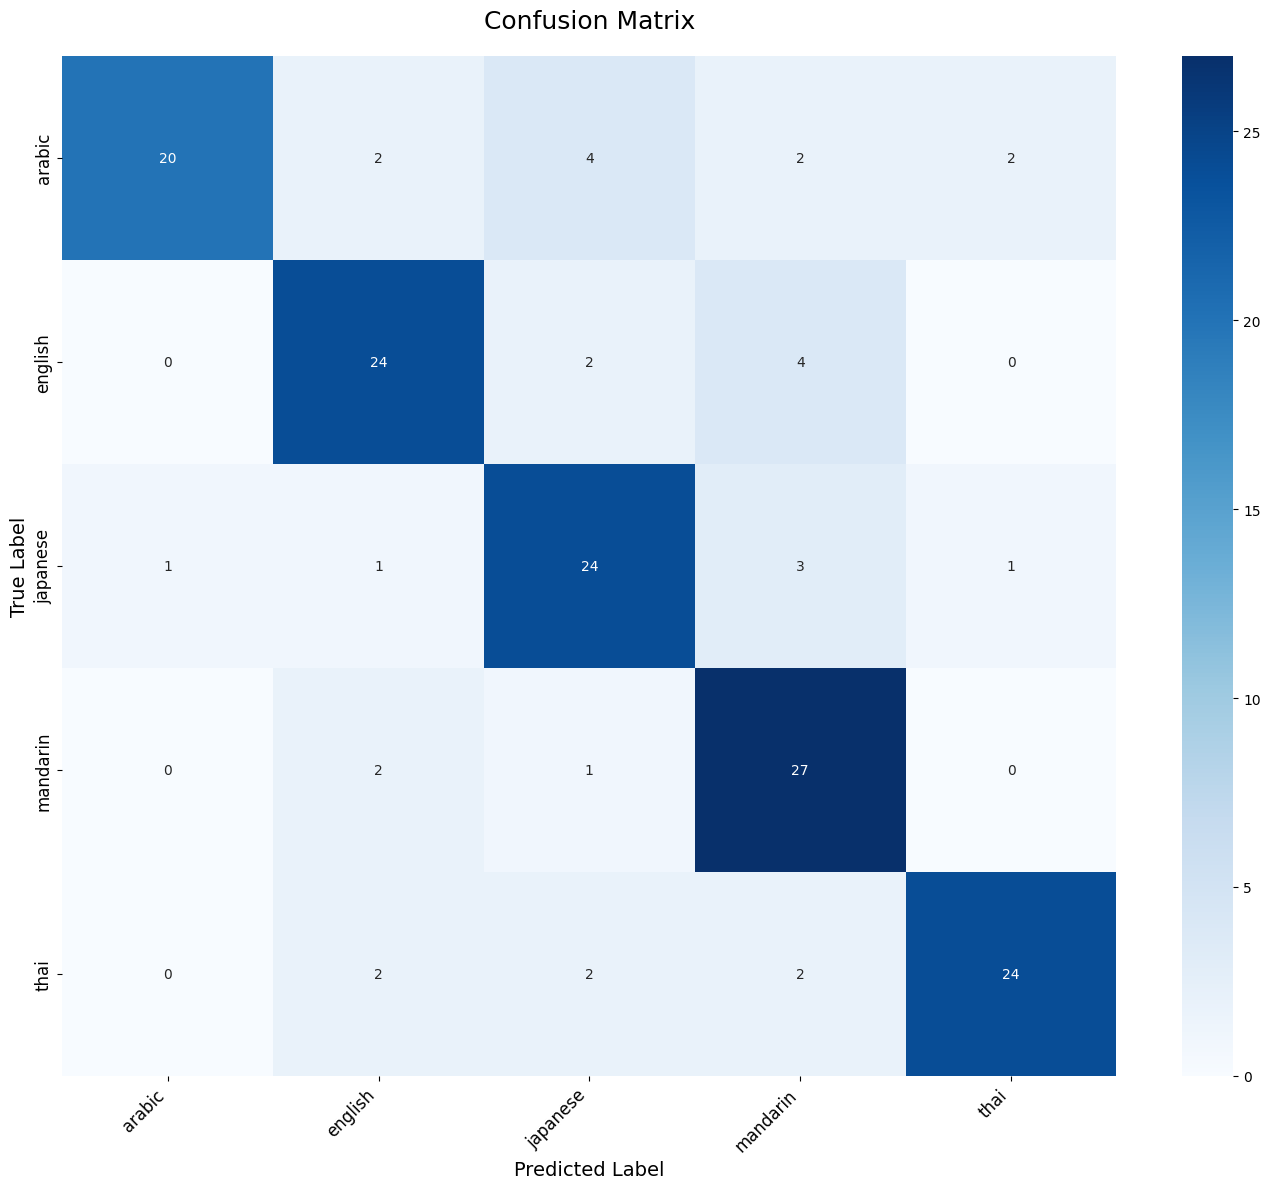

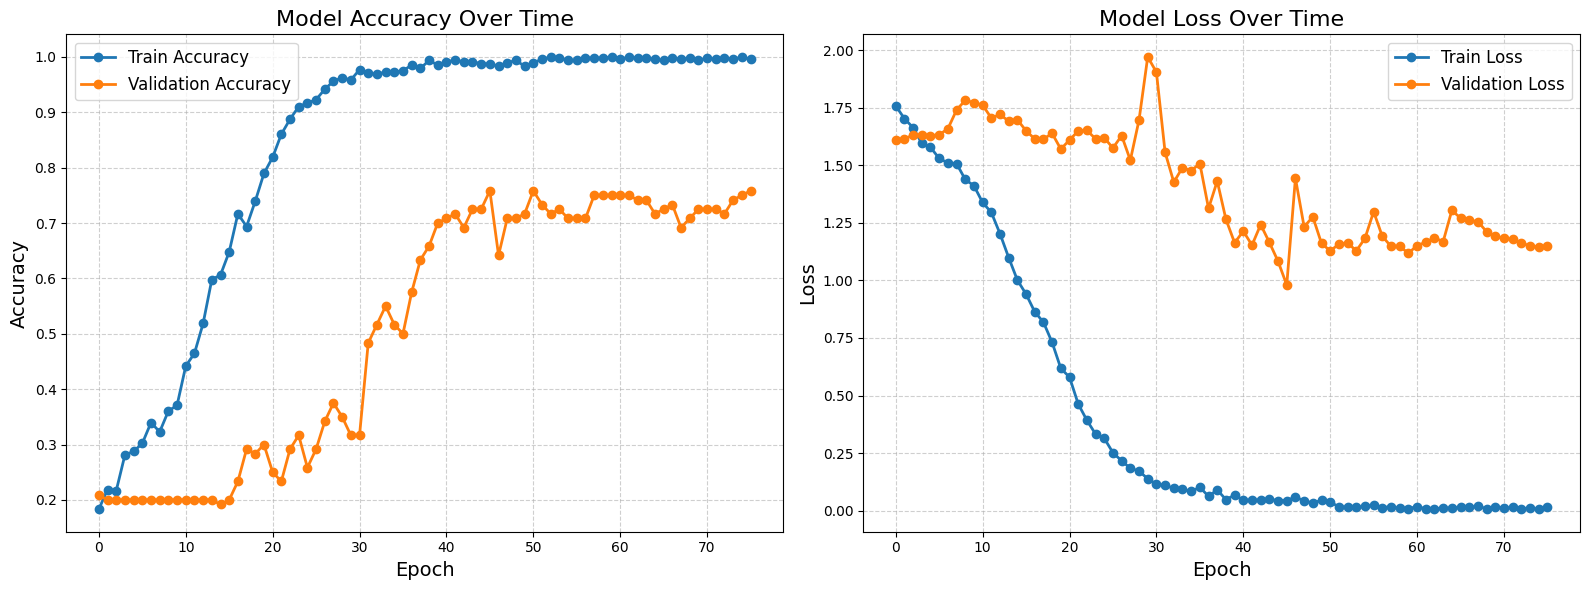

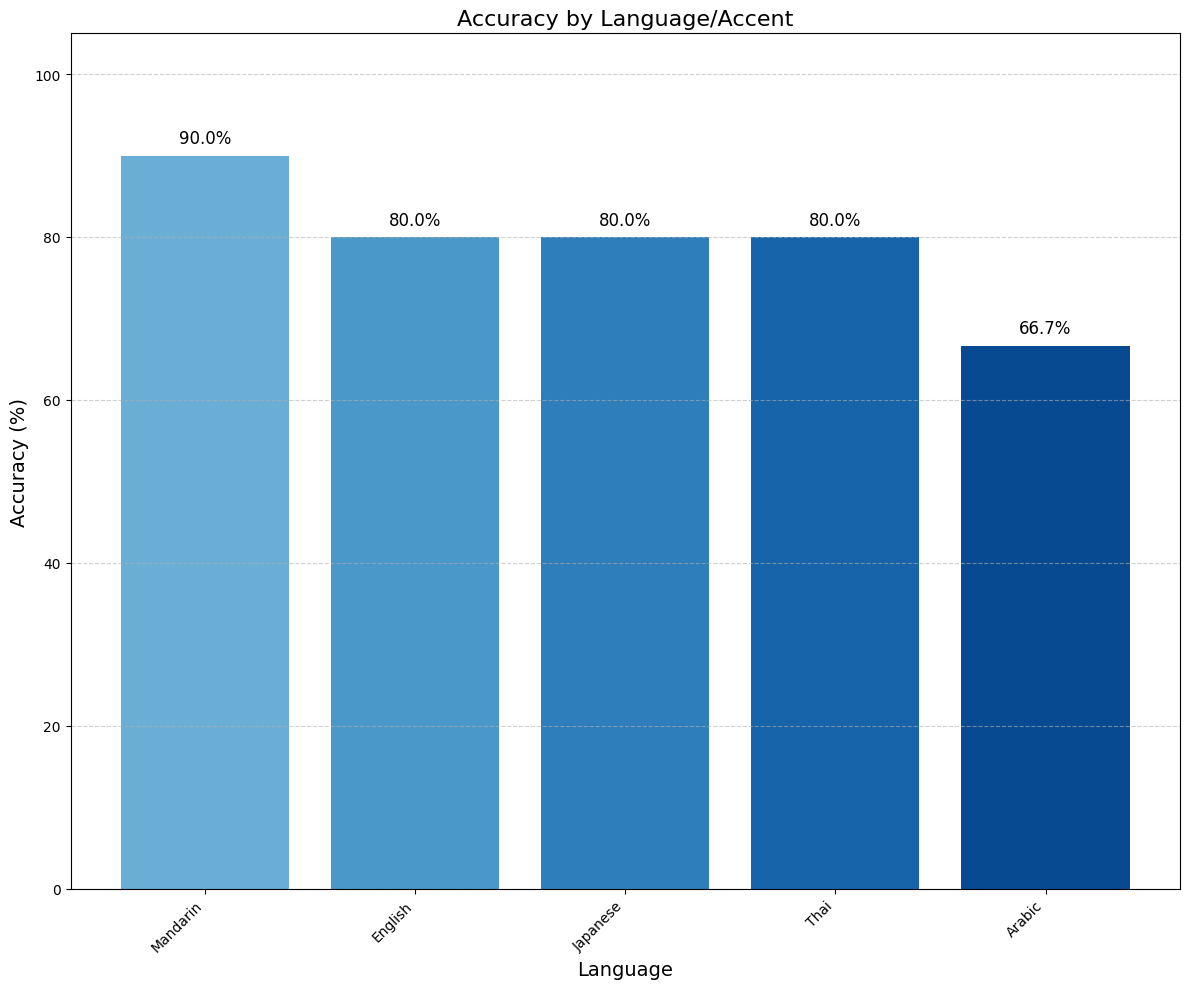


===== ตัวอย่างการทำนาย =====

ตัวอย่างที่ 1:
สำเนียงจริง: mandarin
อันดับ 1: mandarin - 99.4%
อันดับ 2: japanese - 0.4%
อันดับ 3: arabic - 0.1%

ตัวอย่างที่ 2:
สำเนียงจริง: mandarin
อันดับ 1: japanese - 92.2%
อันดับ 2: mandarin - 4.9%
อันดับ 3: arabic - 2.5%

ตัวอย่างที่ 3:
สำเนียงจริง: thai
อันดับ 1: thai - 99.9%
อันดับ 2: english - 0.1%
อันดับ 3: mandarin - 0.0%

ตัวอย่างที่ 4:
สำเนียงจริง: japanese
อันดับ 1: japanese - 82.0%
อันดับ 2: mandarin - 15.8%
อันดับ 3: thai - 1.6%

ตัวอย่างที่ 5:
สำเนียงจริง: arabic
อันดับ 1: japanese - 92.7%
อันดับ 2: arabic - 3.4%
อันดับ 3: mandarin - 3.0%

===== กำลังฝึกสอนโมเดล ResNet =====
Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.2094 - loss: 1.7899
Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to Model\accent_resnet_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.2083 - loss: 1.7907 - val_accuracy: 0.2000 - val_loss: 1.6088 - learning_rate: 3.0000e-04
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3089 - loss: 1.6637
Epoch 2: val_accuracy improved from 0.20000 to 0.21667, saving model to Model\accent_resnet_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.3079 - loss: 1.6628 - val_accuracy: 0.2167 - val_loss: 1.6109 - learning_rate: 3.0000e-04
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.2792 - loss: 1.5801
Epoch 3: val_accuracy did not improve from 0.21667
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.2786 - loss: 1.5802 - val_accuracy: 0.2000 - val_loss: 1.6104 - learning_rate: 3.0000e-04
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3627 - loss: 1.4785
Epoch 4: val_accuracy did not improve from 0.21667
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.3634 - loss: 1.4776 - val_accuracy: 0.2000 - val_loss: 1.6128 - learning_rate: 3.0000e-04
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3699 - loss: 1.4591
Epoch 5: val_accuracy did not improve from 0.21667
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.3719 - loss: 1.4565 - val_accuracy: 0.2000 - val_loss: 1.6099 - learning_rate: 3.0000e-04
Epoch 6/2

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.4560 - loss: 1.3300 - val_accuracy: 0.2250 - val_loss: 1.6219 - learning_rate: 3.0000e-04
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5441 - loss: 1.1341
Epoch 7: val_accuracy did not improve from 0.22500
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.5435 - loss: 1.1350 - val_accuracy: 0.2083 - val_loss: 1.6446 - learning_rate: 3.0000e-04
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6649 - loss: 0.9320
Epoch 8: val_accuracy did not improve from 0.22500
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.6653 - loss: 0.9327 - val_accuracy: 0.1917 - val_loss: 1.7221 - learning_rate: 3.0000e-04
Epoch 9/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6212 - loss: 1.0104
Epoch 9: val_accuracy did not improve from 0.22500
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.6248 - loss: 1.0020 - val_accuracy: 0.2000 - val_loss: 1.9413 - learning_rate: 3.0000e-04
Epoch 10/

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.7644 - loss: 0.6702 - val_accuracy: 0.2417 - val_loss: 1.9155 - learning_rate: 3.0000e-04
Epoch 11/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8622 - loss: 0.4958
Epoch 11: val_accuracy improved from 0.24167 to 0.25000, saving model to Model\accent_resnet_model.h5



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.8627 - loss: 0.4941 - val_accuracy: 0.2500 - val_loss: 2.0936 - learning_rate: 1.5000e-04
Epoch 12/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9262 - loss: 0.3114
Epoch 12: val_accuracy did not improve from 0.25000
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.9261 - loss: 0.3097 - val_accuracy: 0.2000 - val_loss: 1.9608 - learning_rate: 1.5000e-04
Epoch 13/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9371 - loss: 0.2398
Epoch 13: val_accuracy did not improve from 0.25000
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9375 - loss: 0.2395 - val_accuracy: 0.2000 - val_loss: 1.8817 - learning_rate: 1.5000e-04
Epoch 14/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9781 - loss: 0.1634
Epoch 14: val_accuracy did not improve from 0.25000
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.9776 - loss: 0.

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9793 - loss: 0.0662 - val_accuracy: 0.3167 - val_loss: 1.8293 - learning_rate: 1.5000e-04
Epoch 21/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9897 - loss: 0.0593
Epoch 21: val_accuracy did not improve from 0.31667

Epoch 21: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9899 - loss: 0.0591 - val_accuracy: 0.2833 - val_loss: 1.8233 - learning_rate: 7.5000e-05
Epoch 22/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9847 - loss: 0.0586
Epoch 22: val_accuracy did not improve from 0.31667
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9849 - loss: 0.0582 - val_accuracy: 0.2417 - val_loss: 2.4100 - learning_rate: 7.5000e-05
Epoch 23/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9940 - loss: 0.0378
Epoch 23: val_accuracy did not improve from 0.31667
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9939 - loss: 0.

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9962 - loss: 0.0297 - val_accuracy: 0.3417 - val_loss: 1.7517 - learning_rate: 7.5000e-05
Epoch 30/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9976 - loss: 0.0225
Epoch 30: val_accuracy improved from 0.34167 to 0.45000, saving model to Model\accent_resnet_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9975 - loss: 0.0228 - val_accuracy: 0.4500 - val_loss: 1.4307 - learning_rate: 7.5000e-05
Epoch 31/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9999 - loss: 0.0205
Epoch 31: val_accuracy improved from 0.45000 to 0.49167, saving model to Model\accent_resnet_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9997 - loss: 0.0208 - val_accuracy: 0.4917 - val_loss: 1.3311 - learning_rate: 7.5000e-05
Epoch 32/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9991 - loss: 0.0259
Epoch 32: val_accuracy improved from 0.49167 to 0.54167, saving model to Model\accent_resnet_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9989 - loss: 0.0261 - val_accuracy: 0.5417 - val_loss: 1.1757 - learning_rate: 7.5000e-05
Epoch 33/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9871 - loss: 0.0473
Epoch 33: val_accuracy did not improve from 0.54167
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.9874 - loss: 0.0465 - val_accuracy: 0.5333 - val_loss: 1.3950 - learning_rate: 7.5000e-05
Epoch 34/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9994 - loss: 0.0198
Epoch 34: val_accuracy improved from 0.54167 to 0.62500, saving model to Model\accent_resnet_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9993 - loss: 0.0200 - val_accuracy: 0.6250 - val_loss: 0.9888 - learning_rate: 7.5000e-05
Epoch 35/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9997 - loss: 0.0183
Epoch 35: val_accuracy did not improve from 0.62500
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.9996 - loss: 0.0185 - val_accuracy: 0.5833 - val_loss: 1.2975 - learning_rate: 7.5000e-05
Epoch 36/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9958 - loss: 0.0180
Epoch 36: val_accuracy did not improve from 0.62500
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.9957 - loss: 0.0184 - val_accuracy: 0.5667 - val_loss: 1.0566 - learning_rate: 7.5000e-05
Epoch 37/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9877 - loss: 0.0253
Epoch 37: val_accuracy improved from 0.62500 to 0.70833, saving model to Model\accent_resnet_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9877 - loss: 0.0255 - val_accuracy: 0.7083 - val_loss: 0.8334 - learning_rate: 7.5000e-05
Epoch 38/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9991 - loss: 0.0119
Epoch 38: val_accuracy improved from 0.70833 to 0.76667, saving model to Model\accent_resnet_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9988 - loss: 0.0124 - val_accuracy: 0.7667 - val_loss: 0.7029 - learning_rate: 7.5000e-05
Epoch 39/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9996 - loss: 0.0182
Epoch 39: val_accuracy did not improve from 0.76667
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9994 - loss: 0.0183 - val_accuracy: 0.6583 - val_loss: 1.1153 - learning_rate: 7.5000e-05
Epoch 40/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9989 - loss: 0.0192
Epoch 40: val_accuracy did not improve from 0.76667
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.9987 - loss: 0.0195 - val_accuracy: 0.7417 - val_loss: 0.7907 - learning_rate: 7.5000e-05
Epoch 41/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9966 - loss: 0.0173
Epoch 41: val_accuracy improved from 0.76667 to 0.83333, saving model to Model\accent_resnet_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9965 - loss: 0.0174 - val_accuracy: 0.8333 - val_loss: 0.5147 - learning_rate: 7.5000e-05
Epoch 42/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9961 - loss: 0.0147
Epoch 42: val_accuracy did not improve from 0.83333
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.9959 - loss: 0.0150 - val_accuracy: 0.8083 - val_loss: 0.5058 - learning_rate: 7.5000e-05
Epoch 43/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9957 - loss: 0.0208
Epoch 43: val_accuracy did not improve from 0.83333
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9956 - loss: 0.0210 - val_accuracy: 0.7500 - val_loss: 0.7923 - learning_rate: 7.5000e-05
Epoch 44/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9974 - loss: 0.0180
Epoch 44: val_accuracy did not improve from 0.83333
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.9975 - loss: 0.0182 - val_accuracy: 0.7500 - val_loss: 0.8629 - learning_rate: 7.5000e-05
Epo

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 0.0152 - val_accuracy: 0.8417 - val_loss: 0.4766 - learning_rate: 3.7500e-05
Epoch 57/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9990 - loss: 0.0105
Epoch 57: val_accuracy improved from 0.84167 to 0.85000, saving model to Model\accent_resnet_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.9989 - loss: 0.0106 - val_accuracy: 0.8500 - val_loss: 0.3943 - learning_rate: 3.7500e-05
Epoch 58/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9952 - loss: 0.0148
Epoch 58: val_accuracy improved from 0.85000 to 0.86667, saving model to Model\accent_resnet_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9953 - loss: 0.0145 - val_accuracy: 0.8667 - val_loss: 0.3454 - learning_rate: 3.7500e-05
Epoch 59/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9979 - loss: 0.0113
Epoch 59: val_accuracy did not improve from 0.86667
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.9977 - loss: 0.0115 - val_accuracy: 0.8333 - val_loss: 0.4974 - learning_rate: 3.7500e-05
Epoch 60/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 0.0097
Epoch 60: val_accuracy did not improve from 0.86667
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 0.0098 - val_accuracy: 0.7583 - val_loss: 0.6545 - learning_rate: 3.7500e-05
Epoch 61/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9982 - loss: 0.0081
Epoch 61: val_accuracy improved from 0.86667 to 0.87500, saving model to Model\accent_resnet_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9979 - loss: 0.0085 - val_accuracy: 0.8750 - val_loss: 0.3978 - learning_rate: 3.7500e-05
Epoch 62/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9983 - loss: 0.0069
Epoch 62: val_accuracy did not improve from 0.87500
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.9982 - loss: 0.0071 - val_accuracy: 0.8083 - val_loss: 0.6617 - learning_rate: 3.7500e-05
Epoch 63/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9969 - loss: 0.0078
Epoch 63: val_accuracy did not improve from 0.87500
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.9969 - loss: 0.0081 - val_accuracy: 0.8333 - val_loss: 0.5499 - learning_rate: 3.7500e-05
Epoch 64/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9992 - loss: 0.0100
Epoch 64: val_accuracy improved from 0.87500 to 0.88333, saving model to Model\accent_resnet_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9991 - loss: 0.0102 - val_accuracy: 0.8833 - val_loss: 0.4263 - learning_rate: 3.7500e-05
Epoch 65/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 0.0103
Epoch 65: val_accuracy did not improve from 0.88333
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 0.0103 - val_accuracy: 0.8750 - val_loss: 0.3655 - learning_rate: 3.7500e-05
Epoch 66/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9994 - loss: 0.0076
Epoch 66: val_accuracy did not improve from 0.88333
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.9993 - loss: 0.0077 - val_accuracy: 0.8500 - val_loss: 0.4000 - learning_rate: 3.7500e-05
Epoch 67/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9983 - loss: 0.0084
Epoch 67: val_accuracy improved from 0.88333 to 0.89167, saving model to Model\accent_resnet_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9982 - loss: 0.0085 - val_accuracy: 0.8917 - val_loss: 0.3159 - learning_rate: 3.7500e-05
Epoch 68/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9964 - loss: 0.0101
Epoch 68: val_accuracy did not improve from 0.89167
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.9964 - loss: 0.0104 - val_accuracy: 0.8833 - val_loss: 0.3400 - learning_rate: 3.7500e-05
Epoch 69/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9977 - loss: 0.0112
Epoch 69: val_accuracy improved from 0.89167 to 0.90000, saving model to Model\accent_resnet_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9976 - loss: 0.0114 - val_accuracy: 0.9000 - val_loss: 0.3044 - learning_rate: 3.7500e-05
Epoch 70/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9974 - loss: 0.0119
Epoch 70: val_accuracy did not improve from 0.90000
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.9975 - loss: 0.0118 - val_accuracy: 0.8667 - val_loss: 0.3893 - learning_rate: 3.7500e-05
Epoch 71/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9905 - loss: 0.0166
Epoch 71: val_accuracy did not improve from 0.90000
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.9908 - loss: 0.0161 - val_accuracy: 0.8750 - val_loss: 0.3422 - learning_rate: 3.7500e-05
Epoch 72/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9994 - loss: 0.0089
Epoch 72: val_accuracy did not improve from 0.90000
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9993 - loss: 0.0089 - val_accuracy: 0.8917 - val_loss: 0.2946 - learning_rate: 3.7500e-05
Epo

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9942 - loss: 0.0081 - val_accuracy: 0.9167 - val_loss: 0.3156 - learning_rate: 1.8750e-05
Epoch 85/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 1.0000 - loss: 0.0072
Epoch 85: val_accuracy did not improve from 0.91667
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 1.0000 - loss: 0.0072 - val_accuracy: 0.9167 - val_loss: 0.3261 - learning_rate: 1.8750e-05
Epoch 86/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 1.0000 - loss: 0.0042
Epoch 86: val_accuracy did not improve from 0.91667
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.9083 - val_loss: 0.3138 - learning_rate: 1.8750e-05
Epoch 87/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9999 - loss: 0.0040
Epoch 87: val_accuracy did not improve from 0.91667
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.9997 - loss: 0.0041 - val_accuracy: 0.8917 - val_loss: 0.3071 - learning_rate: 1.8750e-05
Epo


===== ผลลัพธ์การทดสอบโมเดล ResNet =====
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8509 - loss: 0.4760

ความแม่นยำบนชุดข้อมูลทดสอบ: 86.00%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step

===== รายงานประสิทธิภาพโมเดล =====
Accuracy: 86.00%
Precision: 86.43%
Recall: 86.00%
F1 Score: 85.99%

===== รายงานการจำแนกประเภทโดยละเอียด =====
              precision    recall  f1-score   support

      arabic       0.84      0.90      0.87        30
     english       0.88      0.77      0.82        30
    japanese       0.81      0.83      0.82        30
    mandarin       0.82      0.93      0.88        30
        thai       0.96      0.87      0.91        30

    accuracy                           0.86       150
   macro avg       0.86      0.86      0.86       150
weighted avg       0.86      0.86      0.86       150



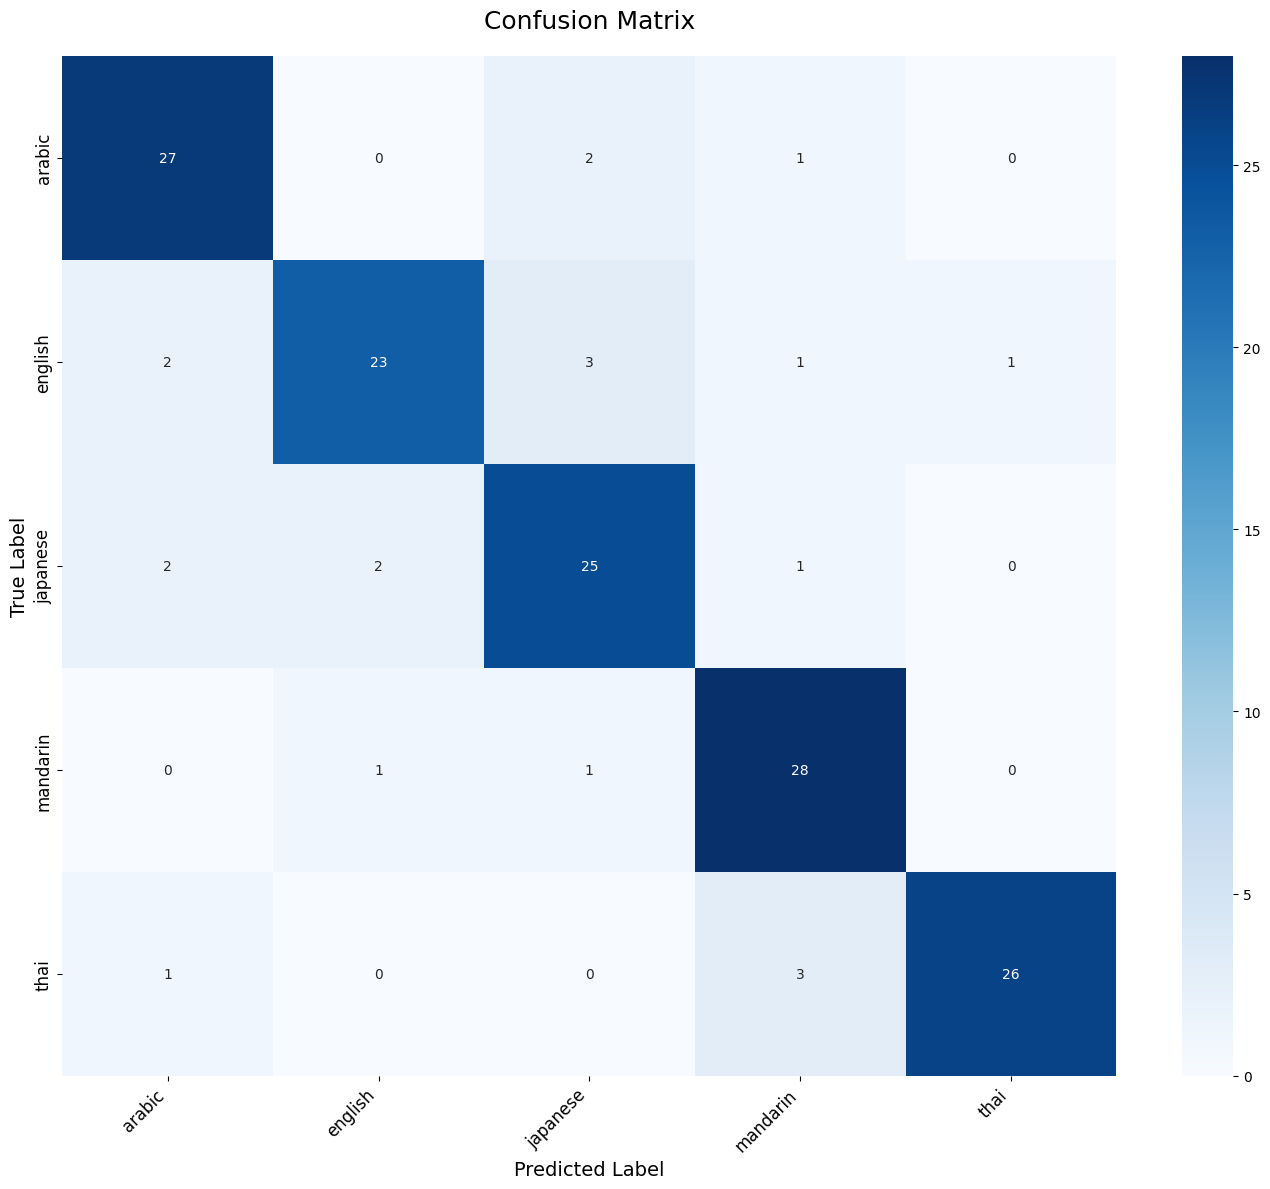

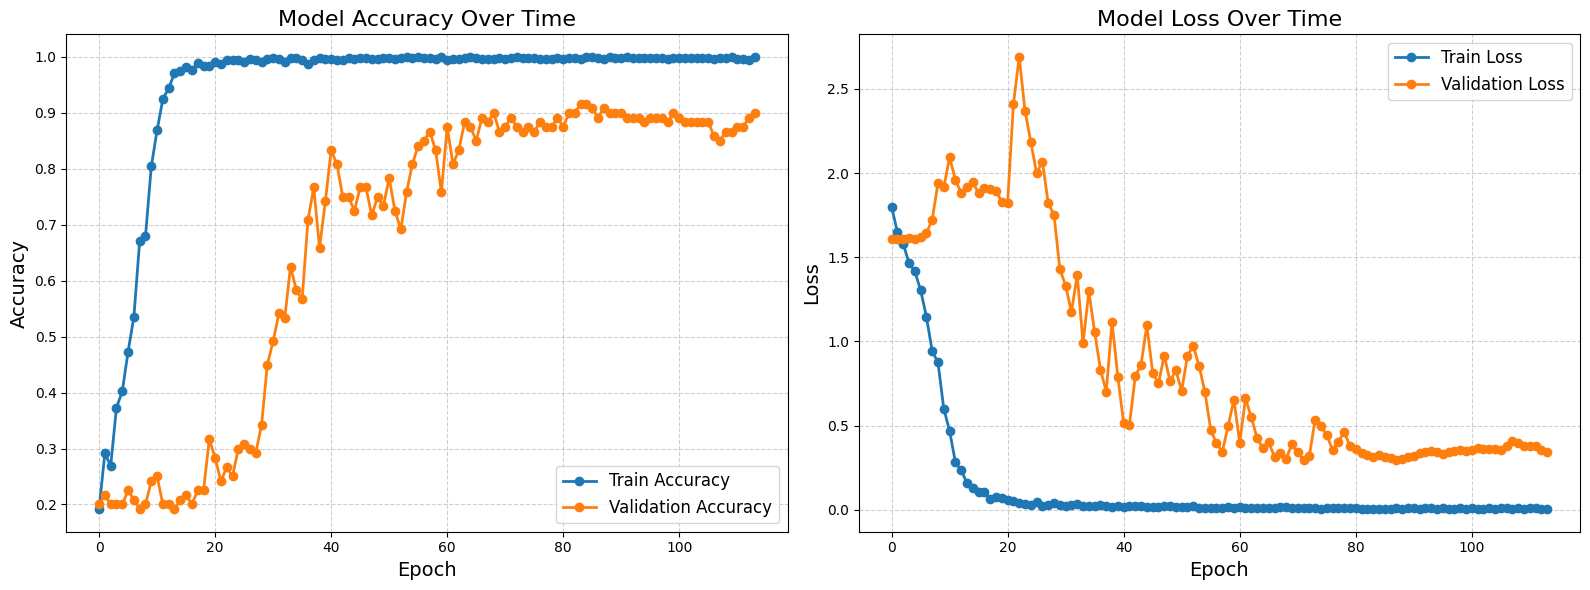

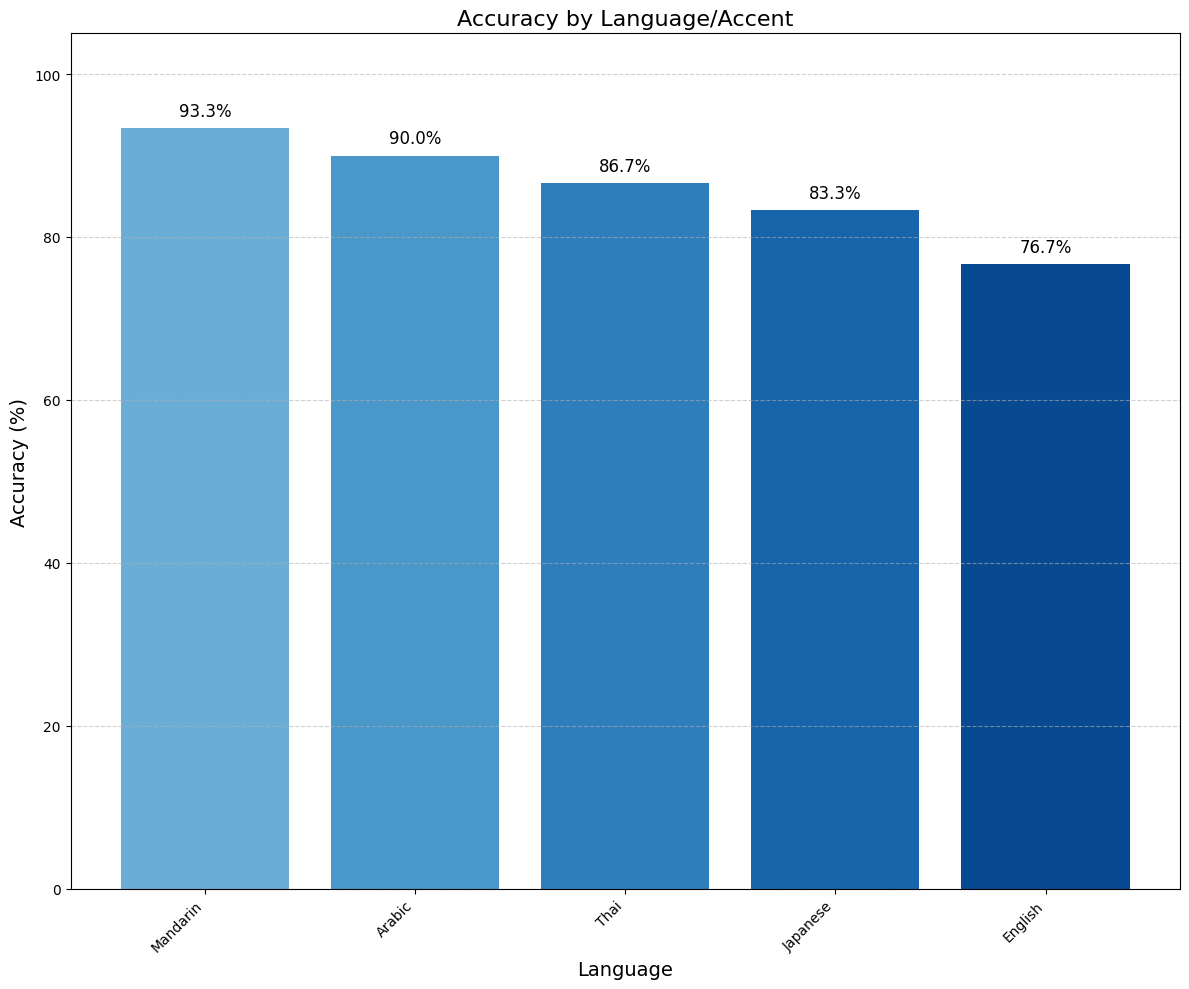


===== ตัวอย่างการทำนาย =====

ตัวอย่างที่ 1:
สำเนียงจริง: mandarin
อันดับ 1: mandarin - 100.0%
อันดับ 2: arabic - 0.0%
อันดับ 3: japanese - 0.0%

ตัวอย่างที่ 2:
สำเนียงจริง: english
อันดับ 1: english - 93.8%
อันดับ 2: japanese - 5.8%
อันดับ 3: thai - 0.2%

ตัวอย่างที่ 3:
สำเนียงจริง: arabic
อันดับ 1: arabic - 100.0%
อันดับ 2: thai - 0.0%
อันดับ 3: japanese - 0.0%

ตัวอย่างที่ 4:
สำเนียงจริง: thai
อันดับ 1: thai - 99.9%
อันดับ 2: arabic - 0.1%
อันดับ 3: mandarin - 0.0%

ตัวอย่างที่ 5:
สำเนียงจริง: arabic
อันดับ 1: arabic - 100.0%
อันดับ 2: thai - 0.0%
อันดับ 3: japanese - 0.0%

===== กำลังสร้างและฝึกสอนโมเดล Ensemble =====
กำลังสร้างโมเดลที่ 1/3...
กำลังสร้างโมเดลที่ 2/3...
กำลังสร้างโมเดลที่ 3/3...



กำลังฝึกสอนโมเดลที่ 1/3...
Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.2445 - loss: 1.7973
Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to Model\accent_ensemble_model_1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 450ms/step - accuracy: 0.2444 - loss: 1.7954 - val_accuracy: 0.2000 - val_loss: 1.6121 - learning_rate: 3.0000e-04
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.2351 - loss: 1.6956
Epoch 2: val_accuracy did not improve from 0.20000
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 380ms/step - accuracy: 0.2357 - loss: 1.6948 - val_accuracy: 0.2000 - val_loss: 1.6222 - learning_rate: 3.0000e-04
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.2499 - loss: 1.6123
Epoch 3: val_accuracy did not improve from 0.20000
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 402ms/step - accuracy: 0.2494 - loss: 1.6135 - val_accuracy: 0.2000 - val_loss: 1.6252 - learning_rate: 3.0000e-04
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.2641 - loss: 1.6053
Epoch 4: val_accuracy did not improve from 0.20000
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 410ms/step - accuracy: 0.2649 - loss: 1.6052 - val_accuracy: 0.2000 - val_loss: 1.6287 - learning_rate: 3.0000e-04
Epoch

15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 506ms/step - accuracy: 0.7340 - loss: 0.7863 - val_accuracy: 0.2083 - val_loss: 1.6902 - learning_rate: 1.5000e-04
Epoch 19/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.7689 - loss: 0.7242
Epoch 19: val_accuracy improved from 0.20833 to 0.21667, saving model to Model\accent_ensemble_model_1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.7683 - loss: 0.7234 - val_accuracy: 0.2167 - val_loss: 1.7215 - learning_rate: 1.5000e-04
Epoch 20/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8348 - loss: 0.5548
Epoch 20: val_accuracy did not improve from 0.21667
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 420ms/step - accuracy: 0.8346 - loss: 0.5547 - val_accuracy: 0.2000 - val_loss: 1.8117 - learning_rate: 1.5000e-04
Epoch 21/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.8387 - loss: 0.5508
Epoch 21: val_accuracy improved from 0.21667 to 0.26667, saving model to Model\accent_ensemble_model_1.h5



Epoch 21: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 398ms/step - accuracy: 0.8379 - loss: 0.5513 - val_accuracy: 0.2667 - val_loss: 1.6152 - learning_rate: 7.5000e-05
Epoch 22/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.8786 - loss: 0.4481
Epoch 22: val_accuracy improved from 0.26667 to 0.29167, saving model to Model\accent_ensemble_model_1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 387ms/step - accuracy: 0.8776 - loss: 0.4490 - val_accuracy: 0.2917 - val_loss: 1.6112 - learning_rate: 7.5000e-05
Epoch 23/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.8944 - loss: 0.3880
Epoch 23: val_accuracy improved from 0.29167 to 0.30000, saving model to Model\accent_ensemble_model_1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 381ms/step - accuracy: 0.8935 - loss: 0.3894 - val_accuracy: 0.3000 - val_loss: 1.6374 - learning_rate: 7.5000e-05
Epoch 24/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.9043 - loss: 0.3670
Epoch 24: val_accuracy improved from 0.30000 to 0.31667, saving model to Model\accent_ensemble_model_1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 386ms/step - accuracy: 0.9042 - loss: 0.3669 - val_accuracy: 0.3167 - val_loss: 1.6663 - learning_rate: 7.5000e-05
Epoch 25/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.9181 - loss: 0.3132
Epoch 25: val_accuracy did not improve from 0.31667
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 375ms/step - accuracy: 0.9180 - loss: 0.3137 - val_accuracy: 0.3083 - val_loss: 1.6603 - learning_rate: 7.5000e-05
Epoch 26/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9128 - loss: 0.3124
Epoch 26: val_accuracy did not improve from 0.31667
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 426ms/step - accuracy: 0.9129 - loss: 0.3114 - val_accuracy: 0.3167 - val_loss: 1.6610 - learning_rate: 7.5000e-05
Epoch 27/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9331 - loss: 0.2550
Epoch 27: val_accuracy improved from 0.31667 to 0.38333, saving model to Model\accent_ensemble_model_1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 439ms/step - accuracy: 0.9337 - loss: 0.2543 - val_accuracy: 0.3833 - val_loss: 1.5452 - learning_rate: 7.5000e-05
Epoch 28/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9391 - loss: 0.2592
Epoch 28: val_accuracy did not improve from 0.38333
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 443ms/step - accuracy: 0.9395 - loss: 0.2574 - val_accuracy: 0.3833 - val_loss: 1.5499 - learning_rate: 7.5000e-05
Epoch 29/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.9445 - loss: 0.2226
Epoch 29: val_accuracy improved from 0.38333 to 0.44167, saving model to Model\accent_ensemble_model_1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 439ms/step - accuracy: 0.9451 - loss: 0.2211 - val_accuracy: 0.4417 - val_loss: 1.4668 - learning_rate: 7.5000e-05
Epoch 30/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9697 - loss: 0.1807
Epoch 30: val_accuracy improved from 0.44167 to 0.47500, saving model to Model\accent_ensemble_model_1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 429ms/step - accuracy: 0.9693 - loss: 0.1801 - val_accuracy: 0.4750 - val_loss: 1.3942 - learning_rate: 7.5000e-05
Epoch 31/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9786 - loss: 0.1638
Epoch 31: val_accuracy improved from 0.47500 to 0.49167, saving model to Model\accent_ensemble_model_1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 415ms/step - accuracy: 0.9782 - loss: 0.1646 - val_accuracy: 0.4917 - val_loss: 1.3552 - learning_rate: 7.5000e-05
Epoch 32/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9542 - loss: 0.1968
Epoch 32: val_accuracy improved from 0.49167 to 0.50833, saving model to Model\accent_ensemble_model_1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 416ms/step - accuracy: 0.9539 - loss: 0.1969 - val_accuracy: 0.5083 - val_loss: 1.3708 - learning_rate: 7.5000e-05
Epoch 33/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9615 - loss: 0.1644
Epoch 33: val_accuracy improved from 0.50833 to 0.51667, saving model to Model\accent_ensemble_model_1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 419ms/step - accuracy: 0.9617 - loss: 0.1640 - val_accuracy: 0.5167 - val_loss: 1.3065 - learning_rate: 7.5000e-05
Epoch 34/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9593 - loss: 0.1502
Epoch 34: val_accuracy improved from 0.51667 to 0.58333, saving model to Model\accent_ensemble_model_1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 417ms/step - accuracy: 0.9598 - loss: 0.1502 - val_accuracy: 0.5833 - val_loss: 1.1649 - learning_rate: 7.5000e-05
Epoch 35/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9701 - loss: 0.1357
Epoch 35: val_accuracy improved from 0.58333 to 0.62500, saving model to Model\accent_ensemble_model_1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 419ms/step - accuracy: 0.9705 - loss: 0.1351 - val_accuracy: 0.6250 - val_loss: 1.1458 - learning_rate: 7.5000e-05
Epoch 36/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9696 - loss: 0.1164
Epoch 36: val_accuracy improved from 0.62500 to 0.66667, saving model to Model\accent_ensemble_model_1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 472ms/step - accuracy: 0.9697 - loss: 0.1172 - val_accuracy: 0.6667 - val_loss: 1.0169 - learning_rate: 7.5000e-05
Epoch 37/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9647 - loss: 0.1308
Epoch 37: val_accuracy improved from 0.66667 to 0.68333, saving model to Model\accent_ensemble_model_1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 433ms/step - accuracy: 0.9656 - loss: 0.1299 - val_accuracy: 0.6833 - val_loss: 0.9763 - learning_rate: 7.5000e-05
Epoch 38/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.9855 - loss: 0.0942
Epoch 38: val_accuracy improved from 0.68333 to 0.71667, saving model to Model\accent_ensemble_model_1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 385ms/step - accuracy: 0.9855 - loss: 0.0943 - val_accuracy: 0.7167 - val_loss: 0.9745 - learning_rate: 7.5000e-05
Epoch 39/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.9646 - loss: 0.1252
Epoch 39: val_accuracy did not improve from 0.71667
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 409ms/step - accuracy: 0.9653 - loss: 0.1239 - val_accuracy: 0.7000 - val_loss: 0.9615 - learning_rate: 7.5000e-05
Epoch 40/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9824 - loss: 0.0950
Epoch 40: val_accuracy improved from 0.71667 to 0.72500, saving model to Model\accent_ensemble_model_1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 414ms/step - accuracy: 0.9825 - loss: 0.0950 - val_accuracy: 0.7250 - val_loss: 0.9136 - learning_rate: 7.5000e-05
Epoch 41/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9808 - loss: 0.0956
Epoch 41: val_accuracy improved from 0.72500 to 0.74167, saving model to Model\accent_ensemble_model_1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 420ms/step - accuracy: 0.9807 - loss: 0.0957 - val_accuracy: 0.7417 - val_loss: 0.8407 - learning_rate: 7.5000e-05
Epoch 42/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9958 - loss: 0.0709
Epoch 42: val_accuracy improved from 0.74167 to 0.75000, saving model to Model\accent_ensemble_model_1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 424ms/step - accuracy: 0.9953 - loss: 0.0717 - val_accuracy: 0.7500 - val_loss: 0.8207 - learning_rate: 7.5000e-05
Epoch 43/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9890 - loss: 0.0700
Epoch 43: val_accuracy improved from 0.75000 to 0.75833, saving model to Model\accent_ensemble_model_1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 417ms/step - accuracy: 0.9888 - loss: 0.0703 - val_accuracy: 0.7583 - val_loss: 0.8168 - learning_rate: 7.5000e-05
Epoch 44/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9929 - loss: 0.0682
Epoch 44: val_accuracy did not improve from 0.75833
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 405ms/step - accuracy: 0.9923 - loss: 0.0689 - val_accuracy: 0.7583 - val_loss: 0.8148 - learning_rate: 7.5000e-05
Epoch 45/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9892 - loss: 0.0533
Epoch 45: val_accuracy did not improve from 0.75833
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 408ms/step - accuracy: 0.9894 - loss: 0.0531 - val_accuracy: 0.7500 - val_loss: 0.8322 - learning_rate: 7.5000e-05
Epoch 46/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9913 - loss: 0.0533
Epoch 46: val_accuracy did not improve from 0.75833
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 401ms/step - accuracy: 0.9911 - loss: 0.0541 - val_accuracy: 0.7583 - val_loss: 0.8552 - learning_rate: 7.5000e-05


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 415ms/step - accuracy: 0.9748 - loss: 0.0973 - val_accuracy: 0.7833 - val_loss: 0.8299 - learning_rate: 7.5000e-05
Epoch 50/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9924 - loss: 0.0558
Epoch 50: val_accuracy did not improve from 0.78333
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 416ms/step - accuracy: 0.9923 - loss: 0.0554 - val_accuracy: 0.7333 - val_loss: 0.8898 - learning_rate: 7.5000e-05
Epoch 51/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9895 - loss: 0.0471
Epoch 51: val_accuracy did not improve from 0.78333
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 406ms/step - accuracy: 0.9898 - loss: 0.0472 - val_accuracy: 0.7583 - val_loss: 0.8420 - learning_rate: 7.5000e-05
Epoch 52/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9881 - loss: 0.0405
Epoch 52: val_accuracy did not improve from 0.78333
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 407ms/step - accuracy: 0.9882 - loss: 0.0404 - val_accuracy: 0.7417 - val_loss: 0.8565 - learning_rate: 7.5000e-05


กำลังฝึกสอนโมเดลที่ 2/3...
Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1923 - loss: 1.8318
Epoch 1: val_accuracy improved from -inf to 0.20833, saving model to Model\accent_ensemble_model_2.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.1938 - loss: 1.8262 - val_accuracy: 0.2083 - val_loss: 1.6081 - learning_rate: 3.0000e-04
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.2425 - loss: 1.6453
Epoch 2: val_accuracy did not improve from 0.20833
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.2427 - loss: 1.6460 - val_accuracy: 0.2000 - val_loss: 1.6126 - learning_rate: 3.0000e-04
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.3345 - loss: 1.5784
Epoch 3: val_accuracy did not improve from 0.20833
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.3322 - loss: 1.5783 - val_accuracy: 0.2000 - val_loss: 1.6211 - learning_rate: 3.0000e-04
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.3267 - loss: 1.5574
Epoch 4: val_accuracy did not improve from 0.20833
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.3264 - loss: 1.5569 - val_accuracy: 0.2000 - val_loss: 1.6328 - learning_rate: 3.0000e-04
Epoch 5/200


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9732 - loss: 0.1156 - val_accuracy: 0.2167 - val_loss: 2.2127 - learning_rate: 1.5000e-04
Epoch 19/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9764 - loss: 0.0852
Epoch 19: val_accuracy did not improve from 0.21667
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9763 - loss: 0.0861 - val_accuracy: 0.1917 - val_loss: 2.1956 - learning_rate: 1.5000e-04
Epoch 20/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9632 - loss: 0.1109
Epoch 20: val_accuracy did not improve from 0.21667
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9635 - loss: 0.1106 - val_accuracy: 0.2000 - val_loss: 2.1586 - learning_rate: 1.5000e-04
Epoch 21/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9467 - loss: 0.1476
Epoch 21: val_accuracy did not improve from 0.21667

Epoch 21: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9478 - loss: 0.145

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9993 - loss: 0.0340 - val_accuracy: 0.2667 - val_loss: 2.1791 - learning_rate: 7.5000e-05
Epoch 27/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9892 - loss: 0.0463
Epoch 27: val_accuracy did not improve from 0.26667
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.9894 - loss: 0.0462 - val_accuracy: 0.2250 - val_loss: 2.2034 - learning_rate: 7.5000e-05
Epoch 28/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9968 - loss: 0.0268
Epoch 28: val_accuracy did not improve from 0.26667
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.9967 - loss: 0.0269 - val_accuracy: 0.2250 - val_loss: 2.2348 - learning_rate: 7.5000e-05
Epoch 29/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9883 - loss: 0.0252
Epoch 29: val_accuracy did not improve from 0.26667
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.9884 - loss: 0.0254 - val_accuracy: 0.2583 - val_loss: 2.1794 - learning_rate: 7.5000e-05
Epo

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9885 - loss: 0.0396 - val_accuracy: 0.3000 - val_loss: 1.9320 - learning_rate: 7.5000e-05
Epoch 31/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9894 - loss: 0.0297
Epoch 31: val_accuracy did not improve from 0.30000

Epoch 31: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.9896 - loss: 0.0296 - val_accuracy: 0.2750 - val_loss: 1.9066 - learning_rate: 3.7500e-05
Epoch 32/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9980 - loss: 0.0188
Epoch 32: val_accuracy improved from 0.30000 to 0.34167, saving model to Model\accent_ensemble_model_2.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9978 - loss: 0.0190 - val_accuracy: 0.3417 - val_loss: 1.8174 - learning_rate: 3.7500e-05
Epoch 33/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9891 - loss: 0.0317
Epoch 33: val_accuracy improved from 0.34167 to 0.47500, saving model to Model\accent_ensemble_model_2.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9894 - loss: 0.0315 - val_accuracy: 0.4750 - val_loss: 1.7094 - learning_rate: 3.7500e-05
Epoch 34/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9944 - loss: 0.0329
Epoch 34: val_accuracy did not improve from 0.47500
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.9945 - loss: 0.0324 - val_accuracy: 0.4750 - val_loss: 1.7277 - learning_rate: 3.7500e-05
Epoch 35/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9892 - loss: 0.0294
Epoch 35: val_accuracy improved from 0.47500 to 0.48333, saving model to Model\accent_ensemble_model_2.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9894 - loss: 0.0293 - val_accuracy: 0.4833 - val_loss: 1.6739 - learning_rate: 3.7500e-05
Epoch 36/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9947 - loss: 0.0232
Epoch 36: val_accuracy improved from 0.48333 to 0.55833, saving model to Model\accent_ensemble_model_2.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9947 - loss: 0.0234 - val_accuracy: 0.5583 - val_loss: 1.5487 - learning_rate: 3.7500e-05
Epoch 37/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9885 - loss: 0.0431
Epoch 37: val_accuracy improved from 0.55833 to 0.61667, saving model to Model\accent_ensemble_model_2.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9887 - loss: 0.0424 - val_accuracy: 0.6167 - val_loss: 1.2125 - learning_rate: 3.7500e-05
Epoch 38/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9913 - loss: 0.0230
Epoch 38: val_accuracy improved from 0.61667 to 0.65833, saving model to Model\accent_ensemble_model_2.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.9914 - loss: 0.0229 - val_accuracy: 0.6583 - val_loss: 1.1148 - learning_rate: 3.7500e-05
Epoch 39/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9818 - loss: 0.0323
Epoch 39: val_accuracy did not improve from 0.65833
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.9822 - loss: 0.0318 - val_accuracy: 0.6583 - val_loss: 1.1137 - learning_rate: 3.7500e-05
Epoch 40/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9945 - loss: 0.0279
Epoch 40: val_accuracy improved from 0.65833 to 0.68333, saving model to Model\accent_ensemble_model_2.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.9944 - loss: 0.0280 - val_accuracy: 0.6833 - val_loss: 0.9989 - learning_rate: 3.7500e-05
Epoch 41/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9916 - loss: 0.0285
Epoch 41: val_accuracy improved from 0.68333 to 0.77500, saving model to Model\accent_ensemble_model_2.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 0.9918 - loss: 0.0282 - val_accuracy: 0.7750 - val_loss: 0.7567 - learning_rate: 3.7500e-05
Epoch 42/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9984 - loss: 0.0147
Epoch 42: val_accuracy improved from 0.77500 to 0.80000, saving model to Model\accent_ensemble_model_2.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.9981 - loss: 0.0154 - val_accuracy: 0.8000 - val_loss: 0.6922 - learning_rate: 3.7500e-05
Epoch 43/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9951 - loss: 0.0203
Epoch 43: val_accuracy did not improve from 0.80000
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.9951 - loss: 0.0203 - val_accuracy: 0.7333 - val_loss: 1.0339 - learning_rate: 3.7500e-05
Epoch 44/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9944 - loss: 0.0202
Epoch 44: val_accuracy did not improve from 0.80000
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.9945 - loss: 0.0202 - val_accuracy: 0.7417 - val_loss: 0.9248 - learning_rate: 3.7500e-05
Epoch 45/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9909 - loss: 0.0261
Epoch 45: val_accuracy improved from 0.80000 to 0.85000, saving model to Model\accent_ensemble_model_2.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9907 - loss: 0.0264 - val_accuracy: 0.8500 - val_loss: 0.4785 - learning_rate: 3.7500e-05
Epoch 46/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9905 - loss: 0.0325
Epoch 46: val_accuracy did not improve from 0.85000
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9904 - loss: 0.0323 - val_accuracy: 0.8500 - val_loss: 0.4821 - learning_rate: 3.7500e-05
Epoch 47/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9925 - loss: 0.0338
Epoch 47: val_accuracy did not improve from 0.85000
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9927 - loss: 0.0330 - val_accuracy: 0.8333 - val_loss: 0.5684 - learning_rate: 3.7500e-05
Epoch 48/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9935 - loss: 0.0195
Epoch 48: val_accuracy did not improve from 0.85000
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9935 - loss: 0.0194 - val_accuracy: 0.8333 - val_loss: 0.5722 - learning_rate: 3.7500e-05


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9938 - loss: 0.0214 - val_accuracy: 0.8583 - val_loss: 0.5471 - learning_rate: 3.7500e-05
Epoch 52/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9976 - loss: 0.0153
Epoch 52: val_accuracy did not improve from 0.85833
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9973 - loss: 0.0158 - val_accuracy: 0.8583 - val_loss: 0.4939 - learning_rate: 3.7500e-05
Epoch 53/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9890 - loss: 0.0385
Epoch 53: val_accuracy did not improve from 0.85833
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9893 - loss: 0.0379 - val_accuracy: 0.8417 - val_loss: 0.4991 - learning_rate: 3.7500e-05
Epoch 54/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9951 - loss: 0.0203
Epoch 54: val_accuracy improved from 0.85833 to 0.87500, saving model to Model\accent_ensemble_model_2.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9950 - loss: 0.0204 - val_accuracy: 0.8750 - val_loss: 0.4168 - learning_rate: 3.7500e-05
Epoch 55/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9991 - loss: 0.0157
Epoch 55: val_accuracy did not improve from 0.87500
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.9988 - loss: 0.0162 - val_accuracy: 0.8667 - val_loss: 0.4730 - learning_rate: 3.7500e-05
Epoch 56/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9933 - loss: 0.0177
Epoch 56: val_accuracy did not improve from 0.87500
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9931 - loss: 0.0181 - val_accuracy: 0.8500 - val_loss: 0.6428 - learning_rate: 3.7500e-05
Epoch 57/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9855 - loss: 0.0320
Epoch 57: val_accuracy did not improve from 0.87500
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9858 - loss: 0.0318 - val_accuracy: 0.8250 - val_loss: 0.6656 - learning_rate: 3.7500e-05


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.9968 - loss: 0.0112 - val_accuracy: 0.8833 - val_loss: 0.5398 - learning_rate: 9.3750e-06
Epoch 80/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9969 - loss: 0.0129
Epoch 80: val_accuracy did not improve from 0.88333
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9969 - loss: 0.0129 - val_accuracy: 0.8750 - val_loss: 0.5106 - learning_rate: 9.3750e-06
Epoch 81/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9952 - loss: 0.0142
Epoch 81: val_accuracy did not improve from 0.88333
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9953 - loss: 0.0141 - val_accuracy: 0.8750 - val_loss: 0.5086 - learning_rate: 9.3750e-06
Epoch 82/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9924 - loss: 0.0152
Epoch 82: val_accuracy did not improve from 0.88333
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9926 - loss: 0.0149 - val_accuracy: 0.8750 - val_loss: 0.5189 - learning_rate: 9.3750e-06


กำลังฝึกสอนโมเดลที่ 3/3...
Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.1736 - loss: 1.9328
Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to Model\accent_ensemble_model_3.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 350ms/step - accuracy: 0.1754 - loss: 1.9253 - val_accuracy: 0.2000 - val_loss: 1.6952 - learning_rate: 1.0000e-04
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.1953 - loss: 1.7128
Epoch 2: val_accuracy did not improve from 0.20000
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - accuracy: 0.1951 - loss: 1.7125 - val_accuracy: 0.2000 - val_loss: 1.6812 - learning_rate: 1.0000e-04
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.2643 - loss: 1.5916
Epoch 3: val_accuracy did not improve from 0.20000
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 360ms/step - accuracy: 0.2629 - loss: 1.5938 - val_accuracy: 0.2000 - val_loss: 1.7022 - learning_rate: 1.0000e-04
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.2203 - loss: 1.6394
Epoch 4: val_accuracy did not improve from 0.20000
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 361ms/step - accuracy: 0.2211 - loss: 1.6390 - val_accuracy: 0.2000 - val_loss: 1.6950 - learning_rate: 1.0000e-04
Epoch

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 393ms/step - accuracy: 0.4345 - loss: 1.3451 - val_accuracy: 0.2333 - val_loss: 1.8787 - learning_rate: 5.0000e-05
Epoch 15/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.4694 - loss: 1.2424
Epoch 15: val_accuracy improved from 0.23333 to 0.24167, saving model to Model\accent_ensemble_model_3.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 385ms/step - accuracy: 0.4704 - loss: 1.2418 - val_accuracy: 0.2417 - val_loss: 1.8922 - learning_rate: 5.0000e-05
Epoch 16/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.5362 - loss: 1.1936
Epoch 16: val_accuracy improved from 0.24167 to 0.26667, saving model to Model\accent_ensemble_model_3.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 374ms/step - accuracy: 0.5338 - loss: 1.1960 - val_accuracy: 0.2667 - val_loss: 1.9002 - learning_rate: 5.0000e-05
Epoch 17/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.5230 - loss: 1.1894
Epoch 17: val_accuracy did not improve from 0.26667
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 359ms/step - accuracy: 0.5236 - loss: 1.1893 - val_accuracy: 0.2500 - val_loss: 1.9086 - learning_rate: 5.0000e-05
Epoch 18/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.5348 - loss: 1.1766
Epoch 18: val_accuracy did not improve from 0.26667
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 303ms/step - accuracy: 0.5351 - loss: 1.1744 - val_accuracy: 0.2167 - val_loss: 1.9447 - learning_rate: 5.0000e-05
Epoch 19/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.4837 - loss: 1.1590
Epoch 19: val_accuracy did not improve from 0.26667
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 366ms/step - accuracy: 0.4837 - loss: 1.1594 - val_accuracy: 0.2333 - val_loss: 1.9862 - learning_rate: 5.0000e-05

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 395ms/step - accuracy: 0.5552 - loss: 1.0273 - val_accuracy: 0.2917 - val_loss: 2.0466 - learning_rate: 5.0000e-05
Epoch 22/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.6152 - loss: 1.0324
Epoch 22: val_accuracy did not improve from 0.29167

Epoch 22: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 385ms/step - accuracy: 0.6142 - loss: 1.0326 - val_accuracy: 0.2750 - val_loss: 2.0661 - learning_rate: 2.5000e-05
Epoch 23/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.6080 - loss: 0.9894
Epoch 23: val_accuracy did not improve from 0.29167
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 386ms/step - accuracy: 0.6086 - loss: 0.9888 - val_accuracy: 0.2917 - val_loss: 2.0737 - learning_rate: 2.5000e-05
Epoch 24/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.6790 - loss: 0.9141
Epoch 24: val_accuracy improved from 0.29167 to 0.30000, saving model to Model\accent_ensemble_model_3.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 380ms/step - accuracy: 0.6785 - loss: 0.9149 - val_accuracy: 0.3000 - val_loss: 2.0896 - learning_rate: 2.5000e-05
Epoch 25/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.6730 - loss: 0.8786
Epoch 25: val_accuracy improved from 0.30000 to 0.30833, saving model to Model\accent_ensemble_model_3.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 401ms/step - accuracy: 0.6742 - loss: 0.8792 - val_accuracy: 0.3083 - val_loss: 2.1169 - learning_rate: 2.5000e-05
Epoch 26/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6707 - loss: 0.8881
Epoch 26: val_accuracy improved from 0.30833 to 0.32500, saving model to Model\accent_ensemble_model_3.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 388ms/step - accuracy: 0.6720 - loss: 0.8864 - val_accuracy: 0.3250 - val_loss: 2.1275 - learning_rate: 2.5000e-05
Epoch 27/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.6283 - loss: 0.9306
Epoch 27: val_accuracy improved from 0.32500 to 0.33333, saving model to Model\accent_ensemble_model_3.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 383ms/step - accuracy: 0.6305 - loss: 0.9276 - val_accuracy: 0.3333 - val_loss: 2.1435 - learning_rate: 2.5000e-05
Epoch 28/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.6688 - loss: 0.8473
Epoch 28: val_accuracy did not improve from 0.33333
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 377ms/step - accuracy: 0.6691 - loss: 0.8466 - val_accuracy: 0.3333 - val_loss: 2.1477 - learning_rate: 2.5000e-05
Epoch 29/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7005 - loss: 0.8193
Epoch 29: val_accuracy improved from 0.33333 to 0.35833, saving model to Model\accent_ensemble_model_3.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 417ms/step - accuracy: 0.7015 - loss: 0.8189 - val_accuracy: 0.3583 - val_loss: 2.1588 - learning_rate: 2.5000e-05
Epoch 30/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.7240 - loss: 0.7463
Epoch 30: val_accuracy did not improve from 0.35833
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 410ms/step - accuracy: 0.7235 - loss: 0.7479 - val_accuracy: 0.3583 - val_loss: 2.1760 - learning_rate: 2.5000e-05
Epoch 31/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.7603 - loss: 0.7655
Epoch 31: val_accuracy improved from 0.35833 to 0.36667, saving model to Model\accent_ensemble_model_3.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 417ms/step - accuracy: 0.7597 - loss: 0.7651 - val_accuracy: 0.3667 - val_loss: 2.1166 - learning_rate: 2.5000e-05
Epoch 32/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.7462 - loss: 0.7436
Epoch 32: val_accuracy improved from 0.36667 to 0.37500, saving model to Model\accent_ensemble_model_3.h5



Epoch 32: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 409ms/step - accuracy: 0.7469 - loss: 0.7423 - val_accuracy: 0.3750 - val_loss: 2.0839 - learning_rate: 1.2500e-05
Epoch 33/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.7794 - loss: 0.6892
Epoch 33: val_accuracy improved from 0.37500 to 0.38333, saving model to Model\accent_ensemble_model_3.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 403ms/step - accuracy: 0.7784 - loss: 0.6914 - val_accuracy: 0.3833 - val_loss: 2.0305 - learning_rate: 1.2500e-05
Epoch 34/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.7153 - loss: 0.7283
Epoch 34: val_accuracy improved from 0.38333 to 0.39167, saving model to Model\accent_ensemble_model_3.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 387ms/step - accuracy: 0.7168 - loss: 0.7279 - val_accuracy: 0.3917 - val_loss: 1.9549 - learning_rate: 1.2500e-05
Epoch 35/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.7634 - loss: 0.6975
Epoch 35: val_accuracy did not improve from 0.39167
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 392ms/step - accuracy: 0.7644 - loss: 0.6965 - val_accuracy: 0.3917 - val_loss: 1.8805 - learning_rate: 1.2500e-05
Epoch 36/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.8241 - loss: 0.6498
Epoch 36: val_accuracy improved from 0.39167 to 0.42500, saving model to Model\accent_ensemble_model_3.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 384ms/step - accuracy: 0.8233 - loss: 0.6507 - val_accuracy: 0.4250 - val_loss: 1.8097 - learning_rate: 1.2500e-05
Epoch 37/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.7839 - loss: 0.6535
Epoch 37: val_accuracy improved from 0.42500 to 0.44167, saving model to Model\accent_ensemble_model_3.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 375ms/step - accuracy: 0.7832 - loss: 0.6550 - val_accuracy: 0.4417 - val_loss: 1.7229 - learning_rate: 1.2500e-05
Epoch 38/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8475 - loss: 0.6206
Epoch 38: val_accuracy improved from 0.44167 to 0.47500, saving model to Model\accent_ensemble_model_3.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 391ms/step - accuracy: 0.8451 - loss: 0.6217 - val_accuracy: 0.4750 - val_loss: 1.6327 - learning_rate: 1.2500e-05
Epoch 39/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8152 - loss: 0.6274
Epoch 39: val_accuracy improved from 0.47500 to 0.49167, saving model to Model\accent_ensemble_model_3.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 388ms/step - accuracy: 0.8147 - loss: 0.6274 - val_accuracy: 0.4917 - val_loss: 1.5433 - learning_rate: 1.2500e-05
Epoch 40/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.7818 - loss: 0.6559
Epoch 40: val_accuracy improved from 0.49167 to 0.50833, saving model to Model\accent_ensemble_model_3.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 389ms/step - accuracy: 0.7824 - loss: 0.6558 - val_accuracy: 0.5083 - val_loss: 1.3953 - learning_rate: 1.2500e-05
Epoch 41/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8199 - loss: 0.5798
Epoch 41: val_accuracy improved from 0.50833 to 0.54167, saving model to Model\accent_ensemble_model_3.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 391ms/step - accuracy: 0.8192 - loss: 0.5810 - val_accuracy: 0.5417 - val_loss: 1.2217 - learning_rate: 1.2500e-05
Epoch 42/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8414 - loss: 0.5640
Epoch 42: val_accuracy improved from 0.54167 to 0.56667, saving model to Model\accent_ensemble_model_3.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 389ms/step - accuracy: 0.8405 - loss: 0.5671 - val_accuracy: 0.5667 - val_loss: 1.1403 - learning_rate: 1.2500e-05
Epoch 43/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.8085 - loss: 0.5784
Epoch 43: val_accuracy improved from 0.56667 to 0.62500, saving model to Model\accent_ensemble_model_3.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 388ms/step - accuracy: 0.8079 - loss: 0.5799 - val_accuracy: 0.6250 - val_loss: 1.0465 - learning_rate: 1.2500e-05
Epoch 44/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.7816 - loss: 0.6131
Epoch 44: val_accuracy did not improve from 0.62500
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 372ms/step - accuracy: 0.7817 - loss: 0.6117 - val_accuracy: 0.6000 - val_loss: 1.0461 - learning_rate: 1.2500e-05
Epoch 45/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8149 - loss: 0.5732
Epoch 45: val_accuracy improved from 0.62500 to 0.68333, saving model to Model\accent_ensemble_model_3.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 390ms/step - accuracy: 0.8149 - loss: 0.5720 - val_accuracy: 0.6833 - val_loss: 0.9385 - learning_rate: 1.2500e-05
Epoch 46/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.8293 - loss: 0.5277
Epoch 46: val_accuracy improved from 0.68333 to 0.69167, saving model to Model\accent_ensemble_model_3.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 381ms/step - accuracy: 0.8279 - loss: 0.5302 - val_accuracy: 0.6917 - val_loss: 0.9220 - learning_rate: 1.2500e-05
Epoch 47/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.8018 - loss: 0.5517
Epoch 47: val_accuracy improved from 0.69167 to 0.72500, saving model to Model\accent_ensemble_model_3.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 398ms/step - accuracy: 0.8022 - loss: 0.5526 - val_accuracy: 0.7250 - val_loss: 0.8878 - learning_rate: 1.2500e-05
Epoch 48/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.8027 - loss: 0.5778
Epoch 48: val_accuracy improved from 0.72500 to 0.73333, saving model to Model\accent_ensemble_model_3.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 387ms/step - accuracy: 0.8036 - loss: 0.5769 - val_accuracy: 0.7333 - val_loss: 0.8284 - learning_rate: 1.2500e-05
Epoch 49/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8509 - loss: 0.4777
Epoch 49: val_accuracy did not improve from 0.73333
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 377ms/step - accuracy: 0.8504 - loss: 0.4791 - val_accuracy: 0.7333 - val_loss: 0.8411 - learning_rate: 1.2500e-05
Epoch 50/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.8448 - loss: 0.5043
Epoch 50: val_accuracy improved from 0.73333 to 0.74167, saving model to Model\accent_ensemble_model_3.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 421ms/step - accuracy: 0.8435 - loss: 0.5067 - val_accuracy: 0.7417 - val_loss: 0.8048 - learning_rate: 1.2500e-05
Epoch 51/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.8594 - loss: 0.4703
Epoch 51: val_accuracy did not improve from 0.74167
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 398ms/step - accuracy: 0.8586 - loss: 0.4715 - val_accuracy: 0.7333 - val_loss: 0.7843 - learning_rate: 1.2500e-05
Epoch 52/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8438 - loss: 0.5472
Epoch 52: val_accuracy did not improve from 0.74167
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 378ms/step - accuracy: 0.8438 - loss: 0.5458 - val_accuracy: 0.7250 - val_loss: 0.8055 - learning_rate: 1.2500e-05
Epoch 53/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.8491 - loss: 0.4963
Epoch 53: val_accuracy did not improve from 0.74167
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 379ms/step - accuracy: 0.8502 - loss: 0.4958 - val_accuracy: 0.7167 - val_loss: 0.7828 - learning_rate: 1.2500e-05


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 391ms/step - accuracy: 0.8600 - loss: 0.4309 - val_accuracy: 0.7500 - val_loss: 0.8173 - learning_rate: 1.2500e-05
Epoch 58/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.8763 - loss: 0.3990
Epoch 58: val_accuracy improved from 0.75000 to 0.75833, saving model to Model\accent_ensemble_model_3.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 395ms/step - accuracy: 0.8752 - loss: 0.4018 - val_accuracy: 0.7583 - val_loss: 0.8013 - learning_rate: 1.2500e-05
Epoch 59/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.8680 - loss: 0.4356
Epoch 59: val_accuracy improved from 0.75833 to 0.78333, saving model to Model\accent_ensemble_model_3.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 398ms/step - accuracy: 0.8686 - loss: 0.4348 - val_accuracy: 0.7833 - val_loss: 0.8229 - learning_rate: 1.2500e-05
Epoch 60/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.8327 - loss: 0.5146
Epoch 60: val_accuracy did not improve from 0.78333
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 379ms/step - accuracy: 0.8339 - loss: 0.5114 - val_accuracy: 0.7583 - val_loss: 0.8393 - learning_rate: 1.2500e-05
Epoch 61/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.8770 - loss: 0.4036
Epoch 61: val_accuracy did not improve from 0.78333
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 378ms/step - accuracy: 0.8765 - loss: 0.4050 - val_accuracy: 0.7500 - val_loss: 0.8423 - learning_rate: 1.2500e-05
Epoch 62/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8479 - loss: 0.4528
Epoch 62: val_accuracy did not improve from 0.78333
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 375ms/step - accuracy: 0.8490 - loss: 0.4530 - val_accuracy: 0.7750 - val_loss: 0.8508 - learning_rate: 1.2500e-05


ValueError: Unknown layer: 'EncoderLayer'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [10]:
def preprocess_audio_file(audio_path, model_dir="Model"):
    """
    แปลงไฟล์เสียงให้เป็นรูปแบบที่เหมาะสมสำหรับการทำนาย
    """
    try:
        # สกัดคุณลักษณะจากไฟล์เสียง
        features = extract_advanced_features(audio_path)
        if features is None:
            return None
        
        # แปลงเป็น numpy array และเพิ่มมิติแบตช์
        features = np.expand_dims(features, axis=0)
        
        return features
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการประมวลผลไฟล์เสียง: {str(e)}")
        return None

def predict_accent(audio_path, model_dir="Model"):
    """
    ทำนายสำเนียงจากไฟล์เสียง
    """
    try:
        # โหลด label encoder
        label_encoder = joblib.load(os.path.join(model_dir, 'label_encoder.pkl'))
        
        # โหลดโมเดล ensemble
        models = []
        for i in range(3):
            model_path = os.path.join(model_dir, f'accent_ensemble_model_{i+1}.h5')
            if os.path.exists(model_path):
                models.append(load_model(model_path))
            else:
                print(f"ไม่พบไฟล์โมเดล {model_path}")
        
        if len(models) == 0:
            # ถ้าไม่มีโมเดล ensemble ให้ใช้โมเดล CNN+RNN แทน
            model_path = os.path.join(model_dir, 'accent_cnn_rnn_model.h5')
            if os.path.exists(model_path):
                model = load_model(model_path)
                models = [model]
            else:
                raise FileNotFoundError("ไม่พบไฟล์โมเดล")
        
        # ประมวลผลไฟล์เสียง
        features = preprocess_audio_file(audio_path, model_dir)
        if features is None:
            return "ไม่สามารถประมวลผลไฟล์เสียงได้"
        
        # ทำนาย
        if len(models) > 1:
            # ใช้ ensemble
            predictions = []
            for model in models:
                pred = model.predict(features)
                predictions.append(pred)
            pred_probs = np.mean(predictions, axis=0)[0]
        else:
            # ใช้โมเดลเดียว
            pred_probs = models[0].predict(features)[0]
        
        # จัดอันดับผลการทำนาย
        top_indices = np.argsort(pred_probs)[::-1]
        
        # แสดงผลลัพธ์
        results = []
        for i, idx in enumerate(top_indices[:3]):  # แสดง 3 อันดับแรก
            accent = label_encoder.classes_[idx]
            confidence = pred_probs[idx] * 100
            results.append((accent, confidence))
        
        return results
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการทำนาย: {str(e)}")
        return "เกิดข้อผิดพลาดในการทำนาย"
if __name__ == "__main__":
    main()


กำลังแสดงภาพคลื่นเสียง...


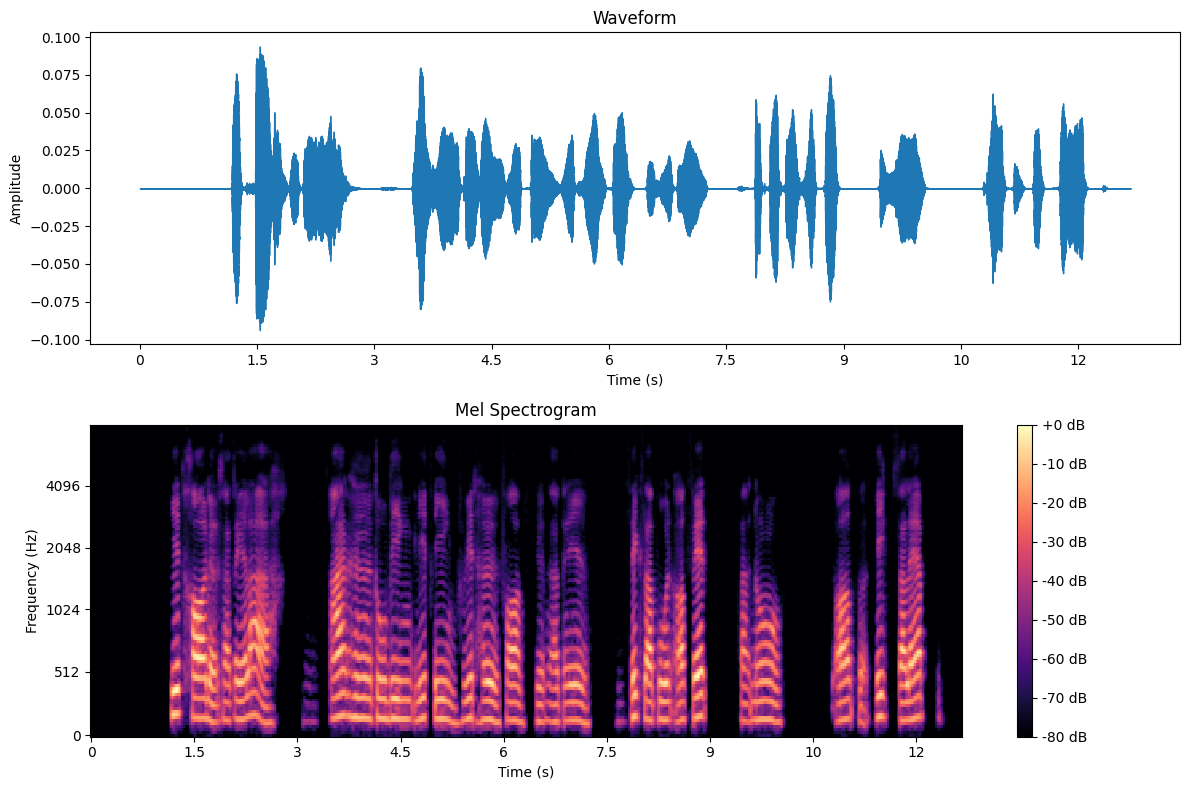


กำลังทำนายสำเนียงภาษา...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step

ทำนายโดยใช้โมเดล: CNN+RNN

===== ผลการทำนายสำเนียง =====
อันดับ 1: thai - 65.7%
อันดับ 2: japanese - 33.3%
อันดับ 3: mandarin - 0.4%


In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import librosa
import librosa.display
import joblib
import cv2
import warnings
warnings.filterwarnings('ignore')

def extract_advanced_features(audio_path, max_length=5.0):
    """
    สกัดคุณลักษณะที่หลากหลายจากไฟล์เสียง
    """
    try:
        # โหลดไฟล์เสียง
        y, sr = librosa.load(audio_path, sr=22050)
        
        # ปรับความยาวเสียงให้เท่ากัน
        target_length = int(max_length * sr)
        
        if len(y) > target_length:
            y = y[:target_length]
        else:
            # Pad with zeros
            padding = target_length - len(y)
            y = np.pad(y, (0, padding), 'constant')
        
        # 1. Mel Spectrogram - ให้ความสำคัญมากที่สุด
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, 
                                                fmax=8000, n_fft=2048, hop_length=512)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # 2. MFCC - Mel-frequency cepstral coefficients
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        delta_mfcc = librosa.feature.delta(mfcc)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)
        
        # รวม features แบบมัลติ-แชนแนล (3 ช่อง)
        # Normalize features
        mel_spec_norm = (mel_spec_db - np.mean(mel_spec_db)) / (np.std(mel_spec_db) + 1e-10)
        mfcc_norm = (mfcc - np.mean(mfcc)) / (np.std(mfcc) + 1e-10)
        delta_norm = (delta_mfcc - np.mean(delta_mfcc)) / (np.std(delta_mfcc) + 1e-10)
        
        # ปรับขนาดให้เท่ากัน
        target_shape = (128, 128)
        mel_spec_resized = cv2.resize(mel_spec_norm, (target_shape[1], target_shape[0]))
        mfcc_resized = cv2.resize(mfcc_norm, (target_shape[1], target_shape[0]))
        delta_resized = cv2.resize(delta_norm, (target_shape[1], target_shape[0]))
        
        # รวมเป็นภาพ 3 ช่อง (RGB-like)
        feature_image = np.stack([mel_spec_resized, mfcc_resized, delta_resized], axis=-1)
        
        # ทำให้ค่าอยู่ระหว่าง 0-1
        feature_image = (feature_image - feature_image.min()) / (feature_image.max() - feature_image.min() + 1e-10)
        
        return feature_image
    except Exception as e:
        print(f"Error extracting features from {audio_path}: {str(e)}")
        return None

def preprocess_audio_file(audio_path):
    """
    แปลงไฟล์เสียงให้เป็นรูปแบบที่เหมาะสมสำหรับการทำนาย
    """
    try:
        # สกัดคุณลักษณะจากไฟล์เสียง
        features = extract_advanced_features(audio_path)
        if features is None:
            return None
        
        # แปลงเป็น numpy array และเพิ่มมิติแบตช์
        features = np.expand_dims(features, axis=0)
        
        return features
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการประมวลผลไฟล์เสียง: {str(e)}")
        return None

def predict_accent(audio_path, model_dir="Model"):
    """
    ทำนายสำเนียงจากไฟล์เสียงโดยใช้โมเดล CNN+RNN หรือ ResNet
    """
    try:
        # โหลด label encoder
        label_encoder = joblib.load(os.path.join(model_dir, 'label_encoder.pkl'))
        
        # โหลดเฉพาะโมเดล CNN+RNN
        model_path = os.path.join(model_dir, 'accent_cnn_rnn_model.h5')
        if os.path.exists(model_path):
            model = load_model(model_path)
            model_name = "CNN+RNN"
        else:
            # ลองใช้ ResNet ถ้าไม่มี CNN+RNN
            model_path = os.path.join(model_dir, 'accent_resnet_model.h5')
            if os.path.exists(model_path):
                model = load_model(model_path)
                model_name = "ResNet"
            else:
                raise FileNotFoundError("ไม่พบไฟล์โมเดล CNN+RNN หรือ ResNet")
        
        # ประมวลผลไฟล์เสียง
        features = preprocess_audio_file(audio_path)
        if features is None:
            return "ไม่สามารถประมวลผลไฟล์เสียงได้"
        
        # ทำนาย
        pred_probs = model.predict(features)[0]
        
        # จัดอันดับผลการทำนาย
        top_indices = np.argsort(pred_probs)[::-1]
        
        # แสดงผลลัพธ์
        results = []
        print(f"\nทำนายโดยใช้โมเดล: {model_name}")
        for i, idx in enumerate(top_indices[:3]):  # แสดง 3 อันดับแรก
            accent = label_encoder.classes_[idx]
            confidence = pred_probs[idx] * 100
            results.append((accent, confidence))
        
        return results
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการทำนาย: {str(e)}")
        return "เกิดข้อผิดพลาดในการทำนาย"

def visualize_audio(audio_path):
    """
    แสดงภาพคลื่นเสียงและ mel spectrogram
    """
    try:
        # โหลดไฟล์เสียง
        y, sr = librosa.load(audio_path, sr=22050)
        
        # สร้างภาพ
        plt.figure(figsize=(12, 8))
        
        # แสดง waveform
        plt.subplot(2, 1, 1)
        librosa.display.waveshow(y, sr=sr)
        plt.title('Waveform')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        
        # แสดง mel spectrogram
        plt.subplot(2, 1, 2)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel Spectrogram')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการแสดงภาพเสียง: {str(e)}")

# ฟังก์ชันหลักสำหรับทดสอบโมเดล
def test_model():
    # ระบุพาธของไฟล์เสียงที่ต้องการทดสอบ
    test_audio_path = input("กรุณาใส่พาธของไฟล์เสียงที่ต้องการทดสอบ: ")
    
    # ตรวจสอบว่าไฟล์มีอยู่จริง
    if not os.path.exists(test_audio_path):
        print(f"ไม่พบไฟล์เสียงที่: {test_audio_path}")
        return
    
    # ระบุโฟลเดอร์ที่เก็บโมเดล
    model_dir = input("กรุณาใส่พาธของโฟลเดอร์ที่เก็บโมเดล (หรือกด Enter เพื่อใช้ค่าเริ่มต้น 'Model'): ")
    if not model_dir:
        model_dir = "Model"
    
    # แสดงภาพคลื่นเสียง
    print("\nกำลังแสดงภาพคลื่นเสียง...")
    visualize_audio(test_audio_path)
    
    # ทำนายสำเนียงภาษา
    print("\nกำลังทำนายสำเนียงภาษา...")
    results = predict_accent(test_audio_path, model_dir)
    
    # แสดงผลลัพธ์
    if isinstance(results, list):
        print("\n===== ผลการทำนายสำเนียง =====")
        for i, (accent, confidence) in enumerate(results):
            print(f"อันดับ {i+1}: {accent} - {confidence:.1f}%")
    else:
        print(results)

# รันฟังก์ชันหลัก
if __name__ == "__main__":
    test_model()